In [1]:
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tabulate import tabulate

from utils import *
from evaluate import evaluate, save_predictions
from metrics import calculate_dtw_distances, calculate_dtw_for_index, plot_dtw_alignment_for_index, calculate_wasserstein_distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
device_name = 'cuda:1'
name = "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999"
cfg_scale = 2
noise_steps = 30
epoch = 40

#-------------------------------------------------------------
predictions_path = "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_test_data.csv"
model_path = "models/" + name + "/ema_ckpt" + str(epoch) + ".pt"

# Make predictions on test data

In [3]:
# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.strip('[]').split(','))))


In [4]:
df_preds = pd.read_csv(predictions_path)
df_preds.head()

x_real  \
0  0.0,0.0,0.0,6.81,10.17,0.0,0.74,0.0,3.6,6.82,5...   
1  0.0,0.0,0.0,6.81,6.17,0.0,1.74,3.86,0.0,5.82,5...   
2  0.77,0.0,0.0,5.81,6.17,0.0,1.74,0.86,0.0,5.82,...   
3  0.0,0.0,0.0,2.81,4.17,0.0,6.74,1.86,0.6,8.82,7...   
4  0.77,0.0,1.02,10.81,9.17,0.0,3.74,1.86,0.0,5.8...   

                                        cond_vectors  \
0  0.1299,-0.7678,0.2274,-1.4864,-1.0,-1.0,-0.351...   
1  0.1299,-0.7678,0.2274,-1.4563,-1.0,-1.0,-0.351...   
2  0.1299,-0.7678,0.2165,-1.4203,-1.0,-1.0,-0.351...   
3  0.1299,-0.7678,0.2165,-1.4203,-1.0,-1.0,-0.351...   
4  0.1299,-0.7678,0.2061,-1.4203,-1.0,-1.0,-0.351...   

                                         predictions  
0  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....  
1  2.6039958,3.3537624,2.8488278,3.7228706,3.6450...  
2  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....  
3  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....  
4  4.5259595,3.184855,4.231882,4.962909,5.208671,...

In [5]:
x_real = np.array([str_to_float_list(row) for row in df_preds['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df_preds['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df_preds['predictions']])

In [6]:
mse_error = np.mean((x_real - predictions) ** 2)
print(f"MSE error: {mse_error:.6f}")

MSE error: 2612.671054


# Visualization of results

In [7]:
wavelengths = np.load('../data/wavelengths.npy')

In [8]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

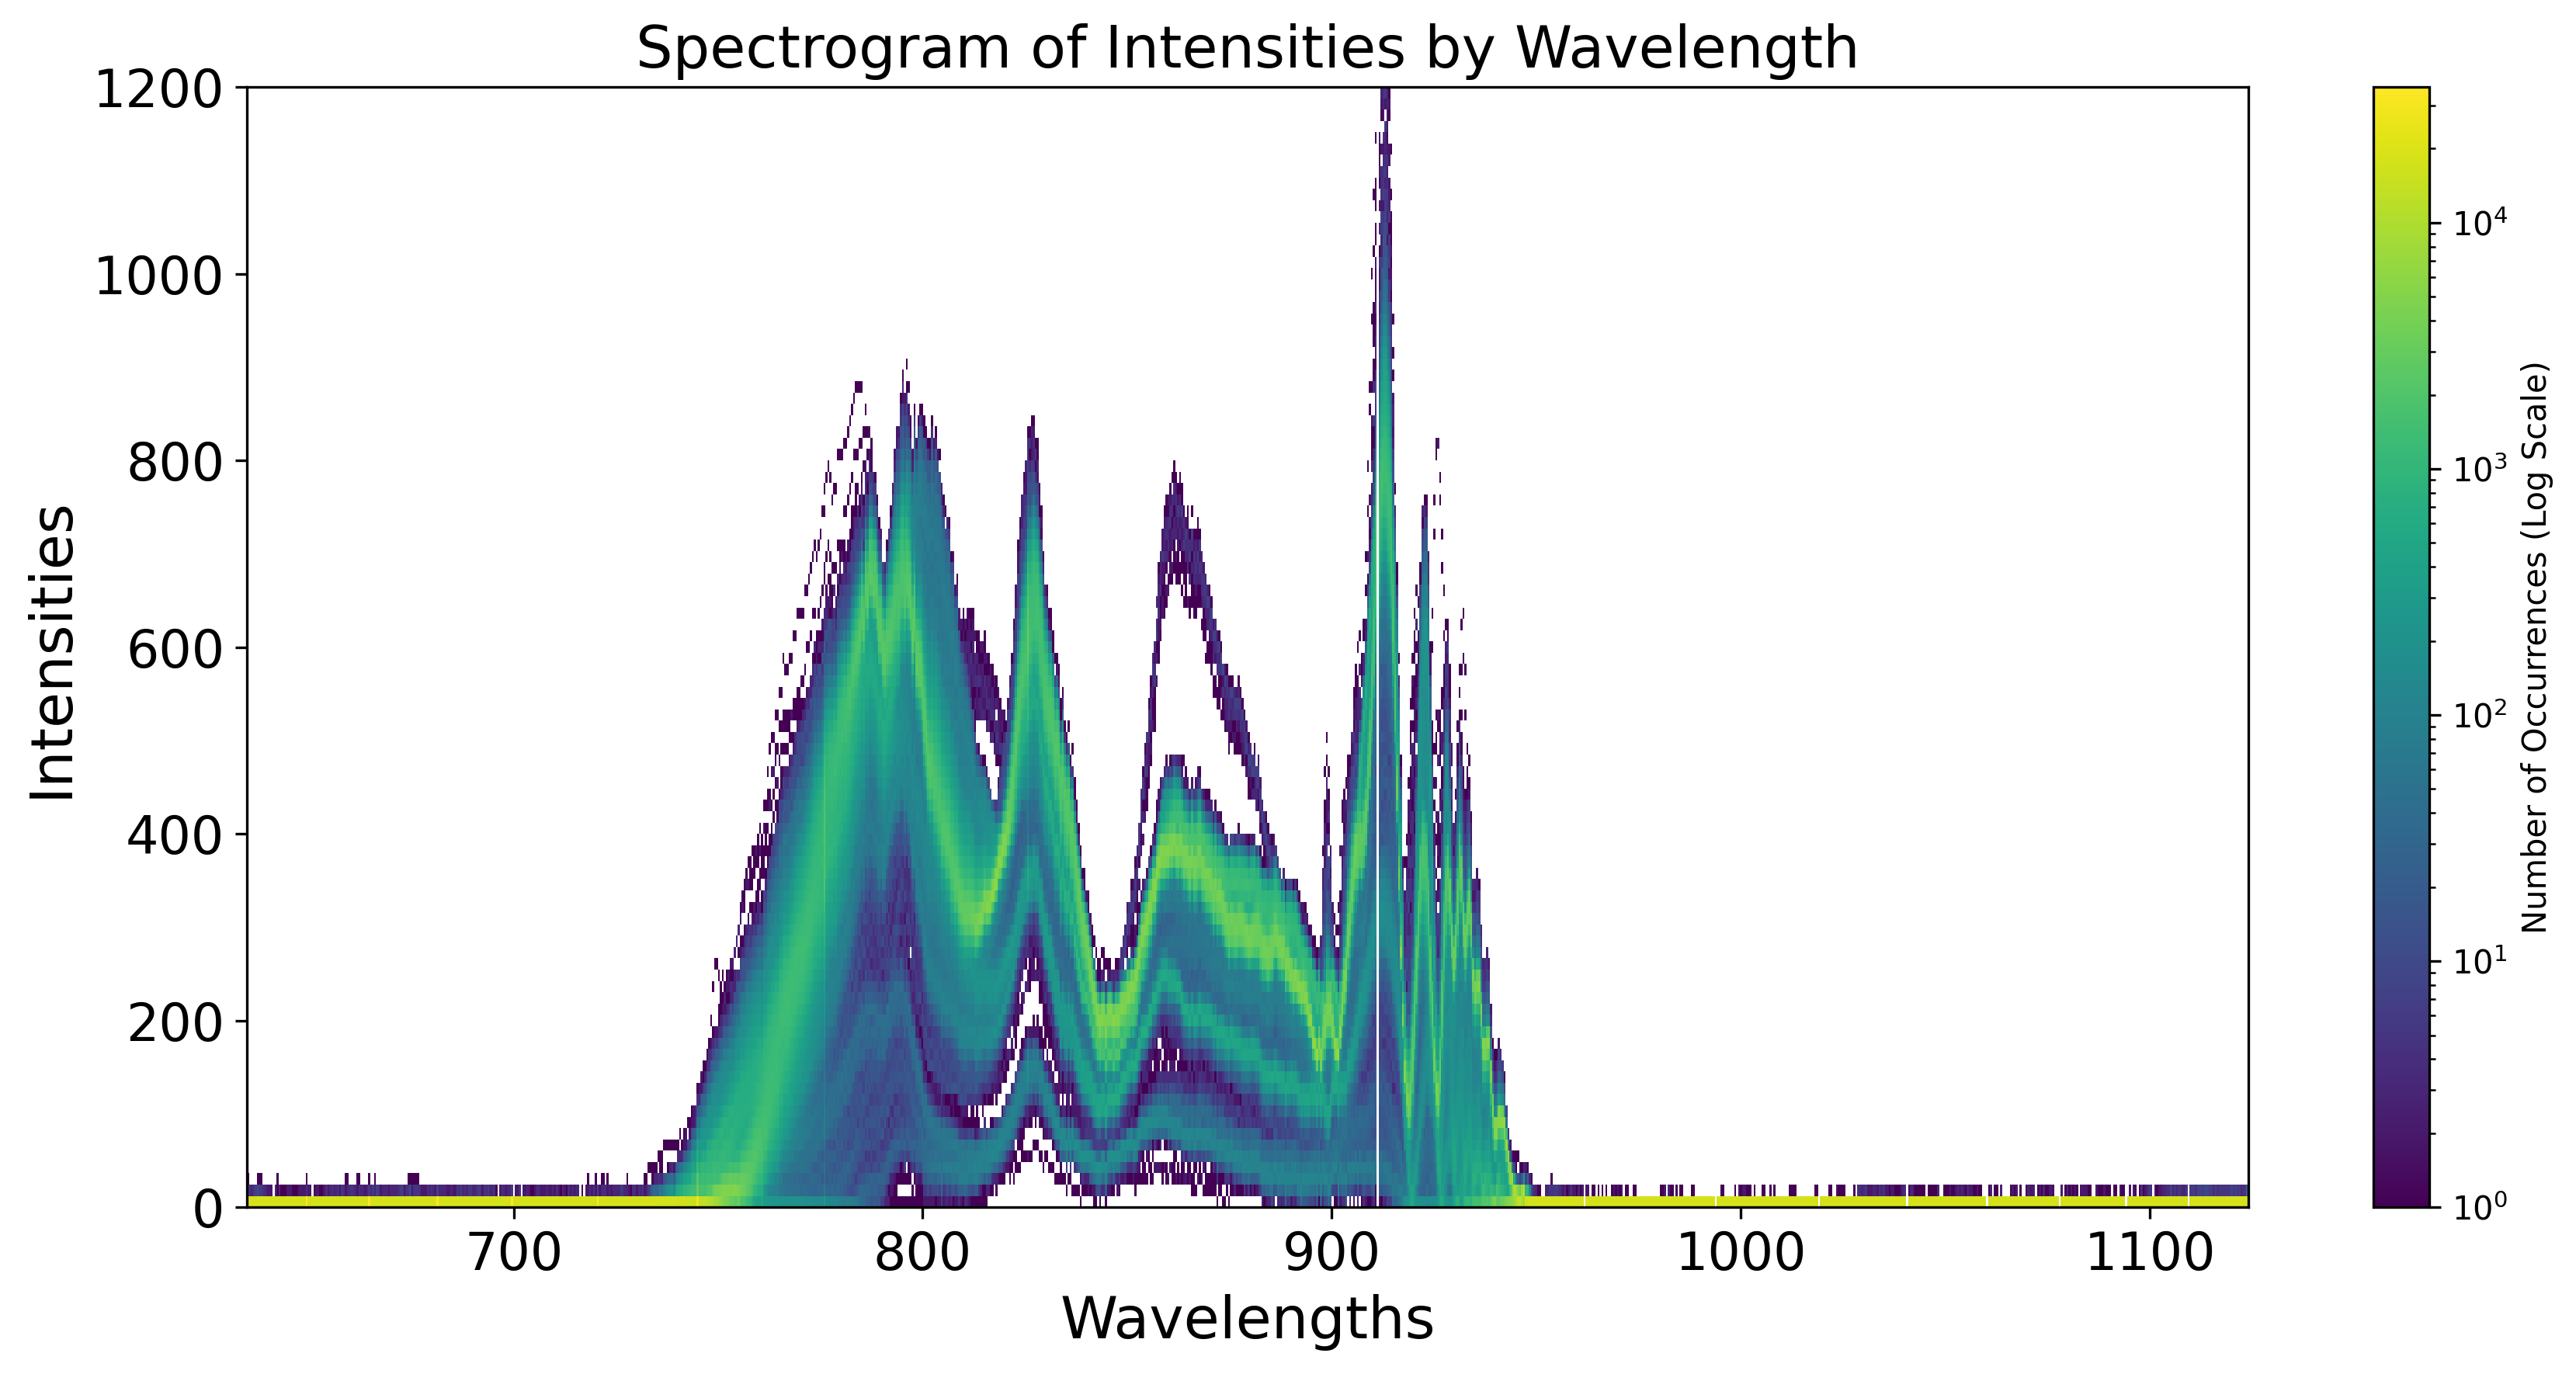

In [9]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

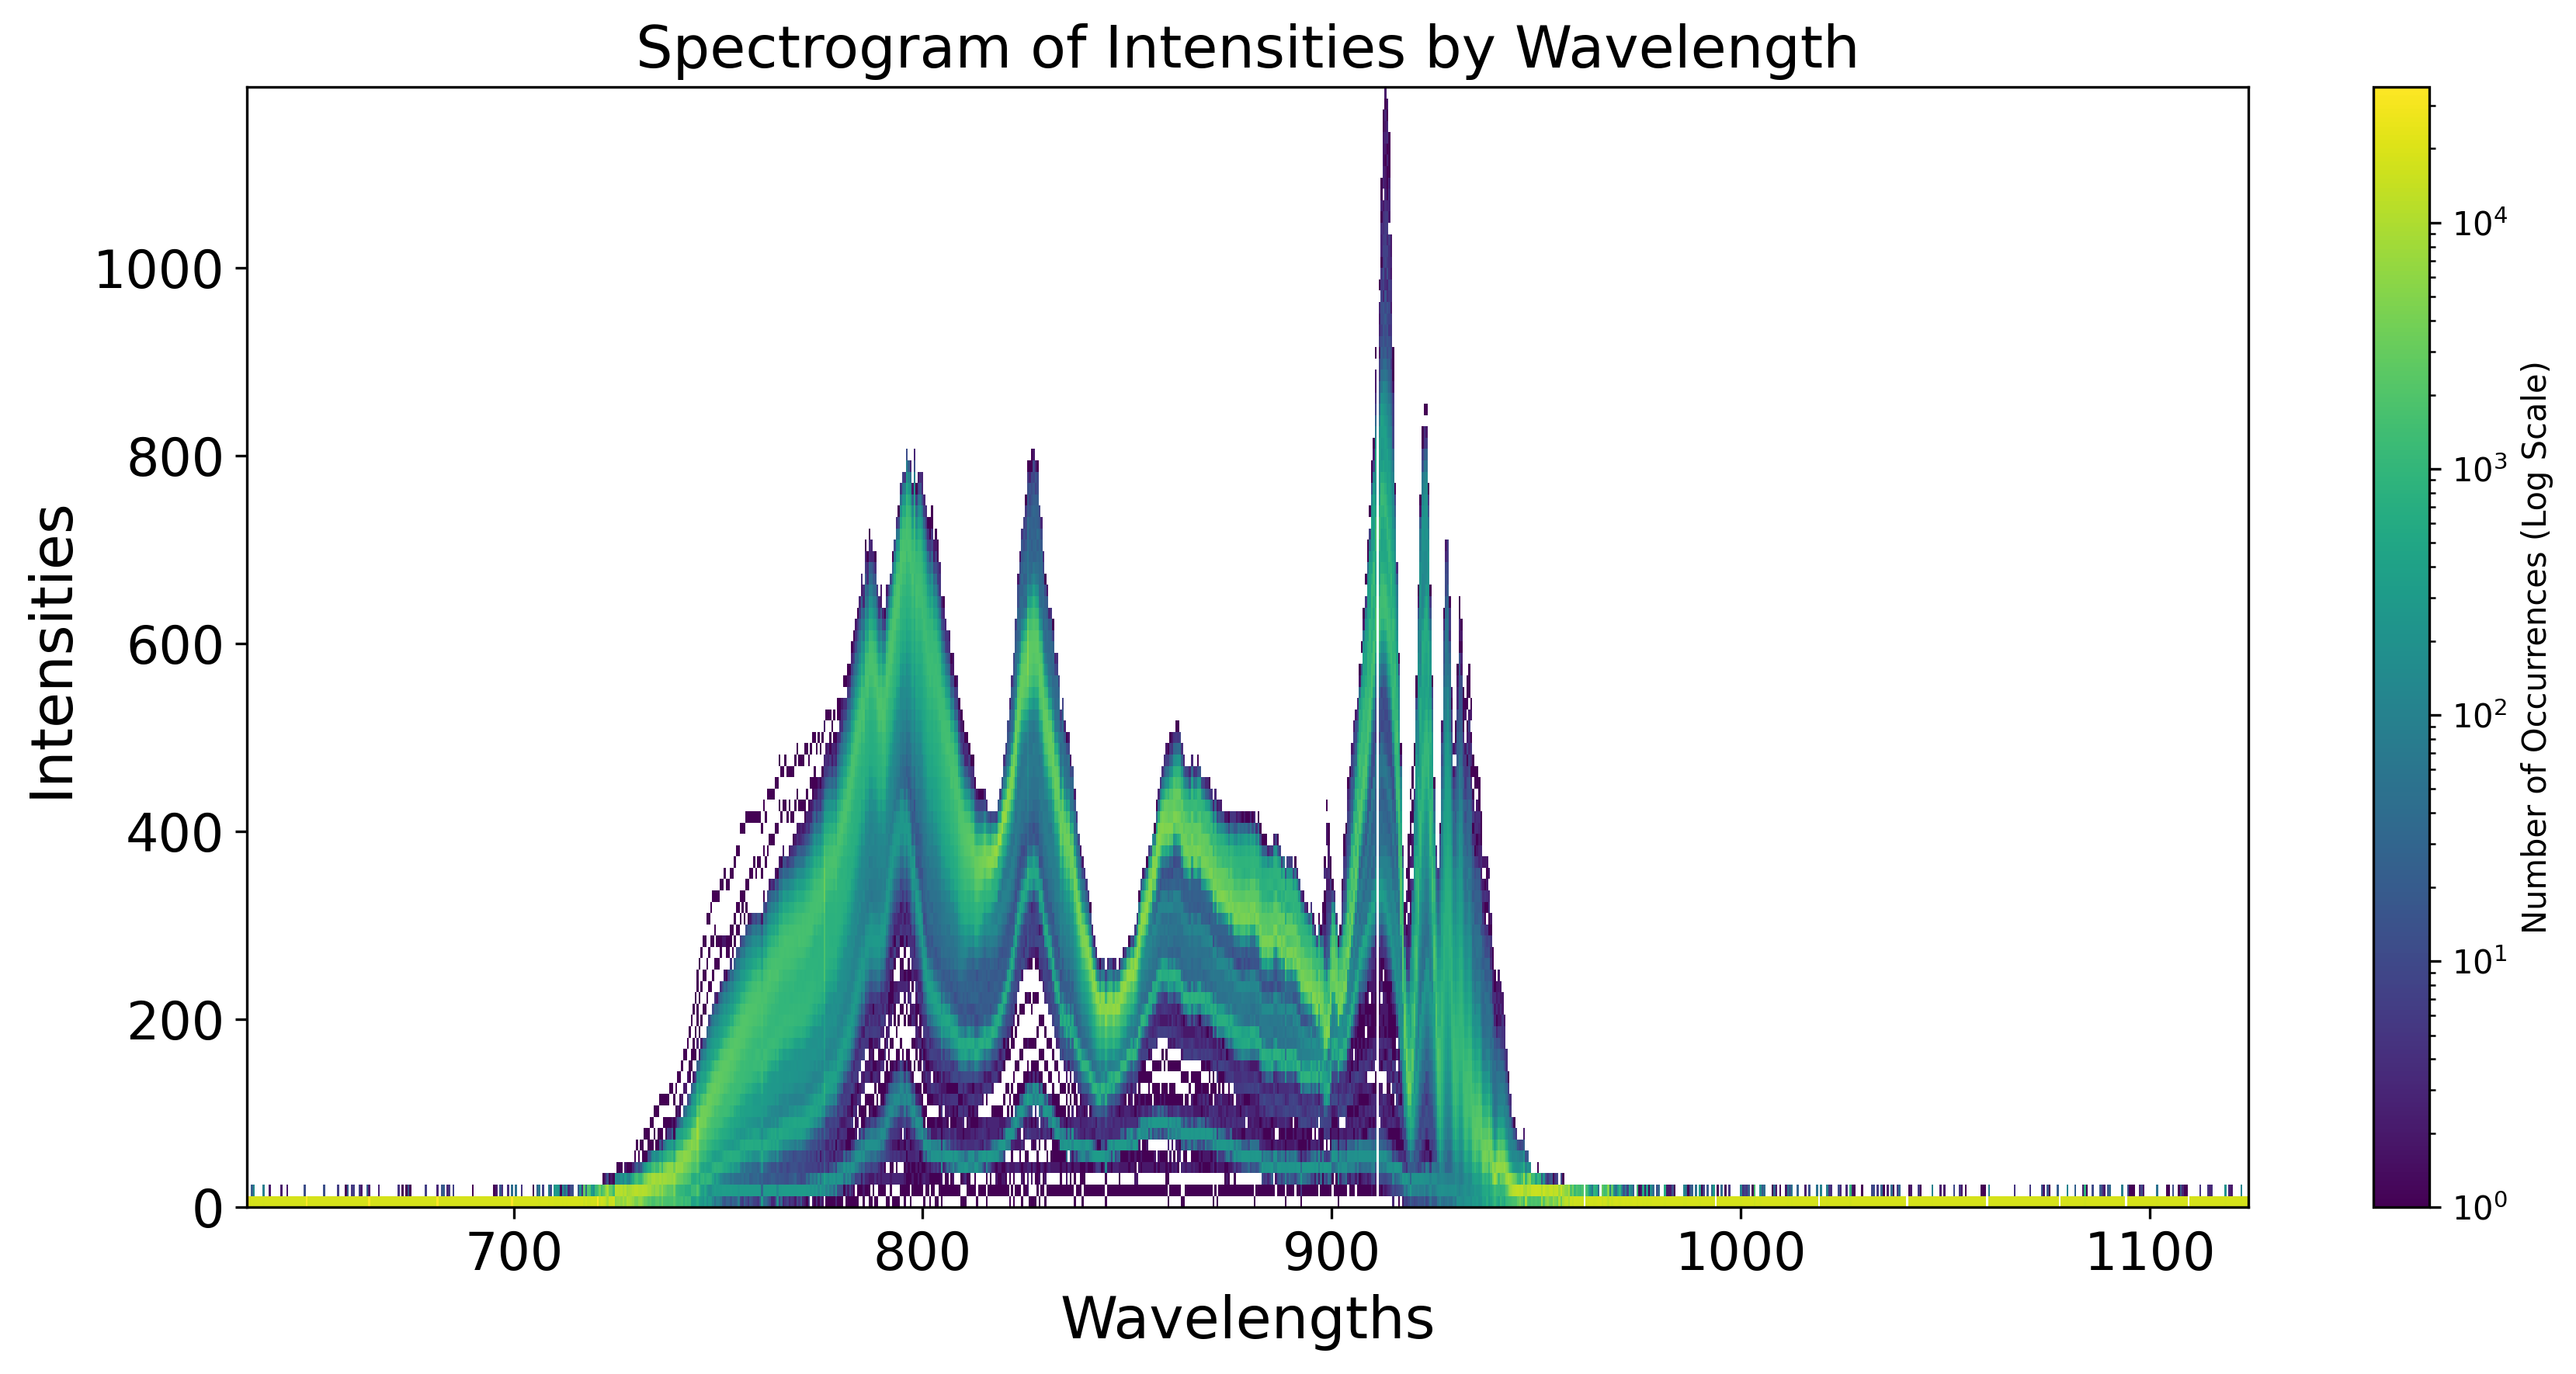

In [10]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

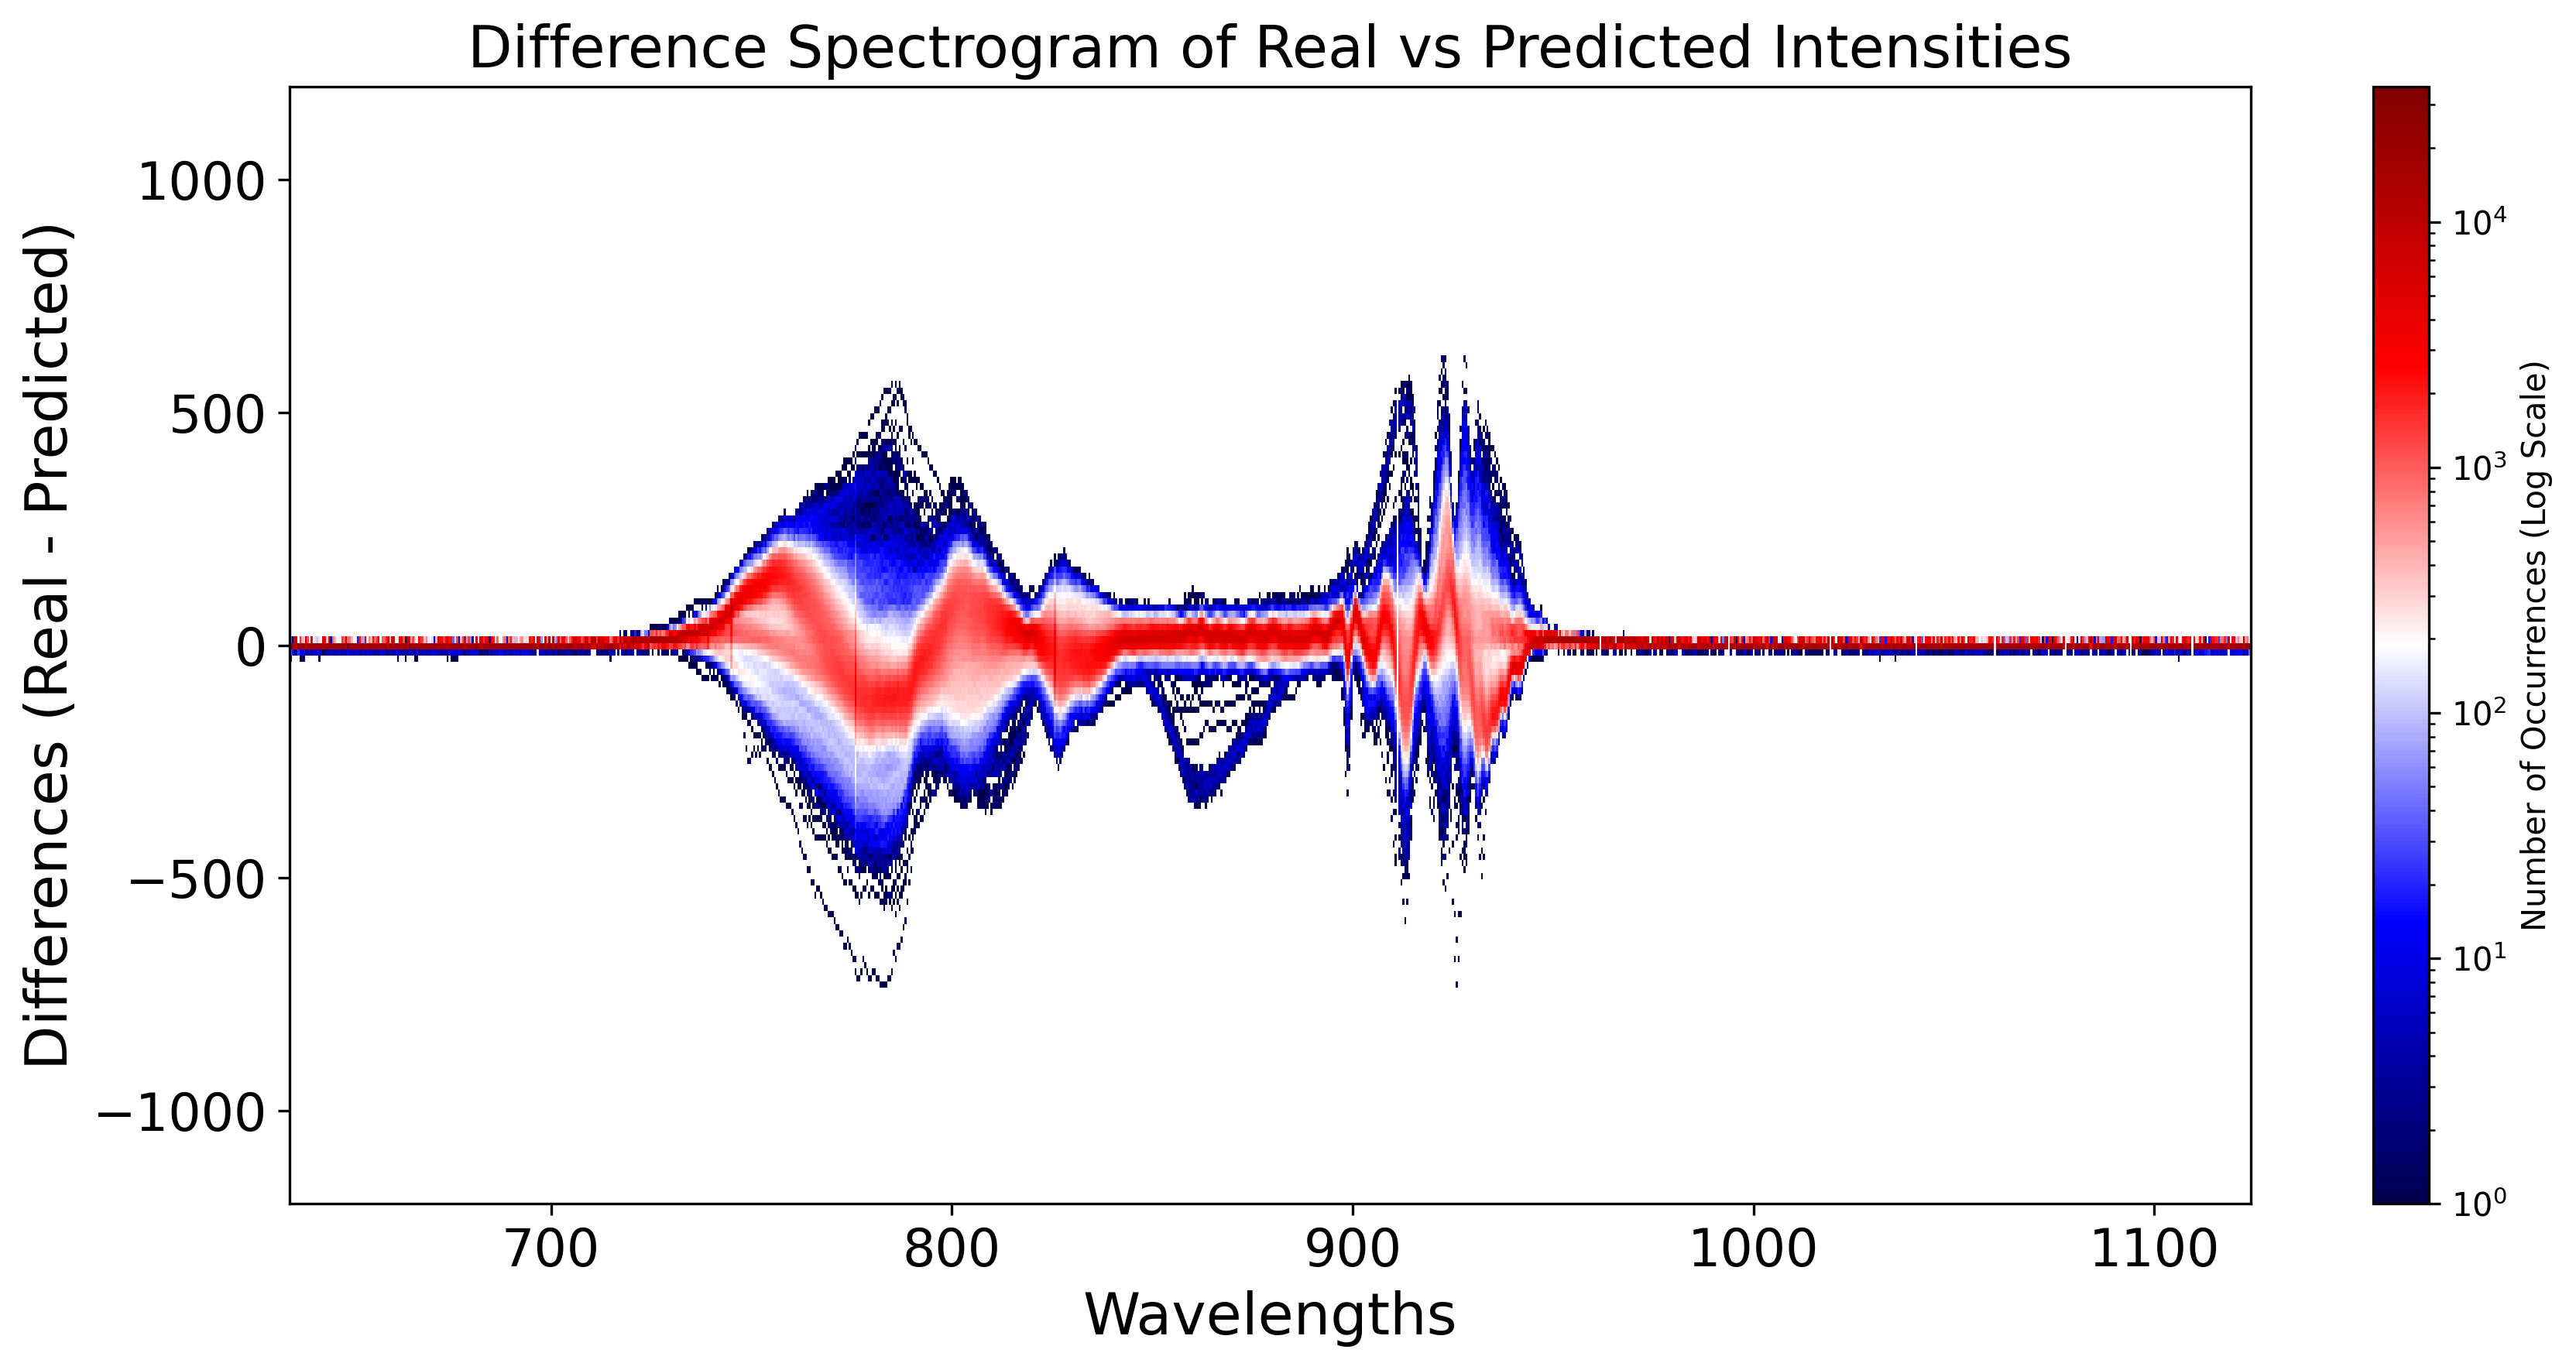

In [11]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
         
                              
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

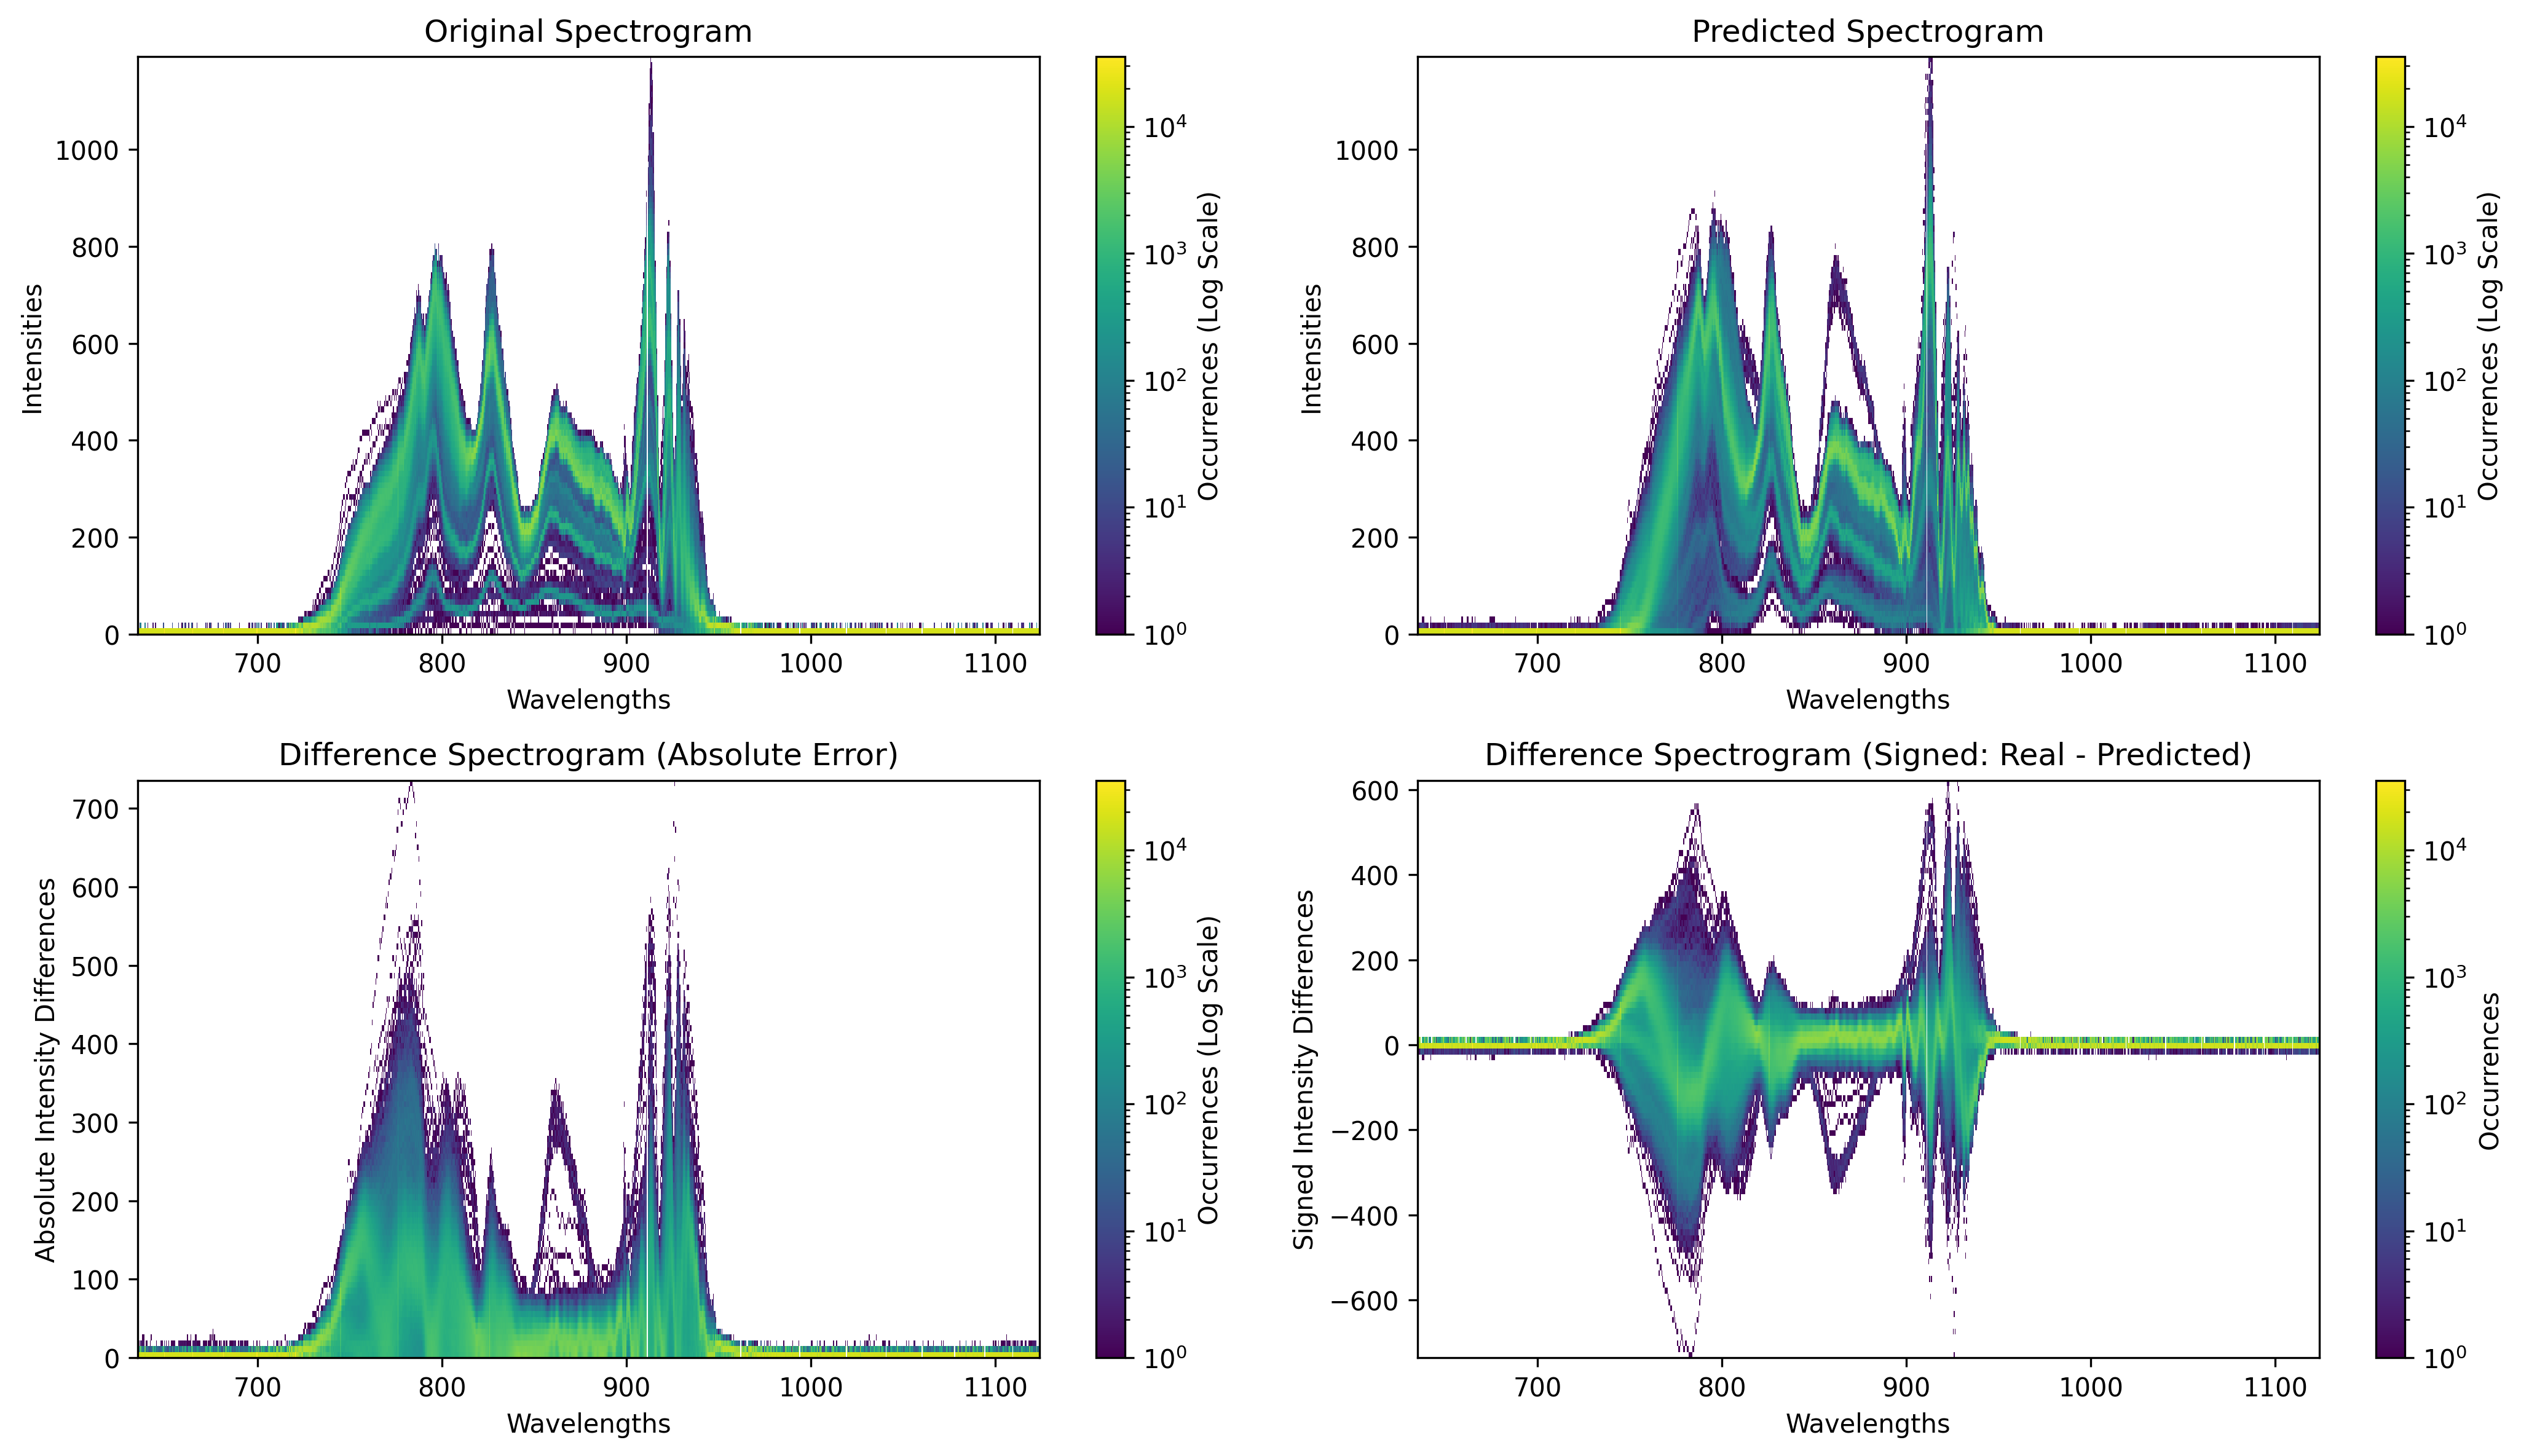

In [12]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

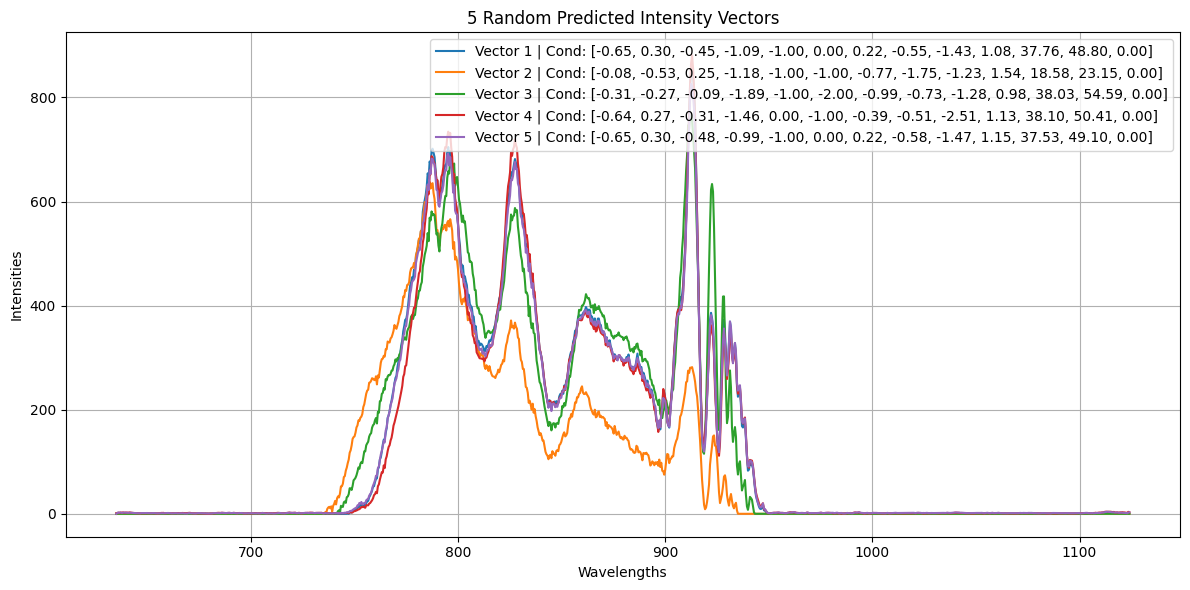

In [13]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

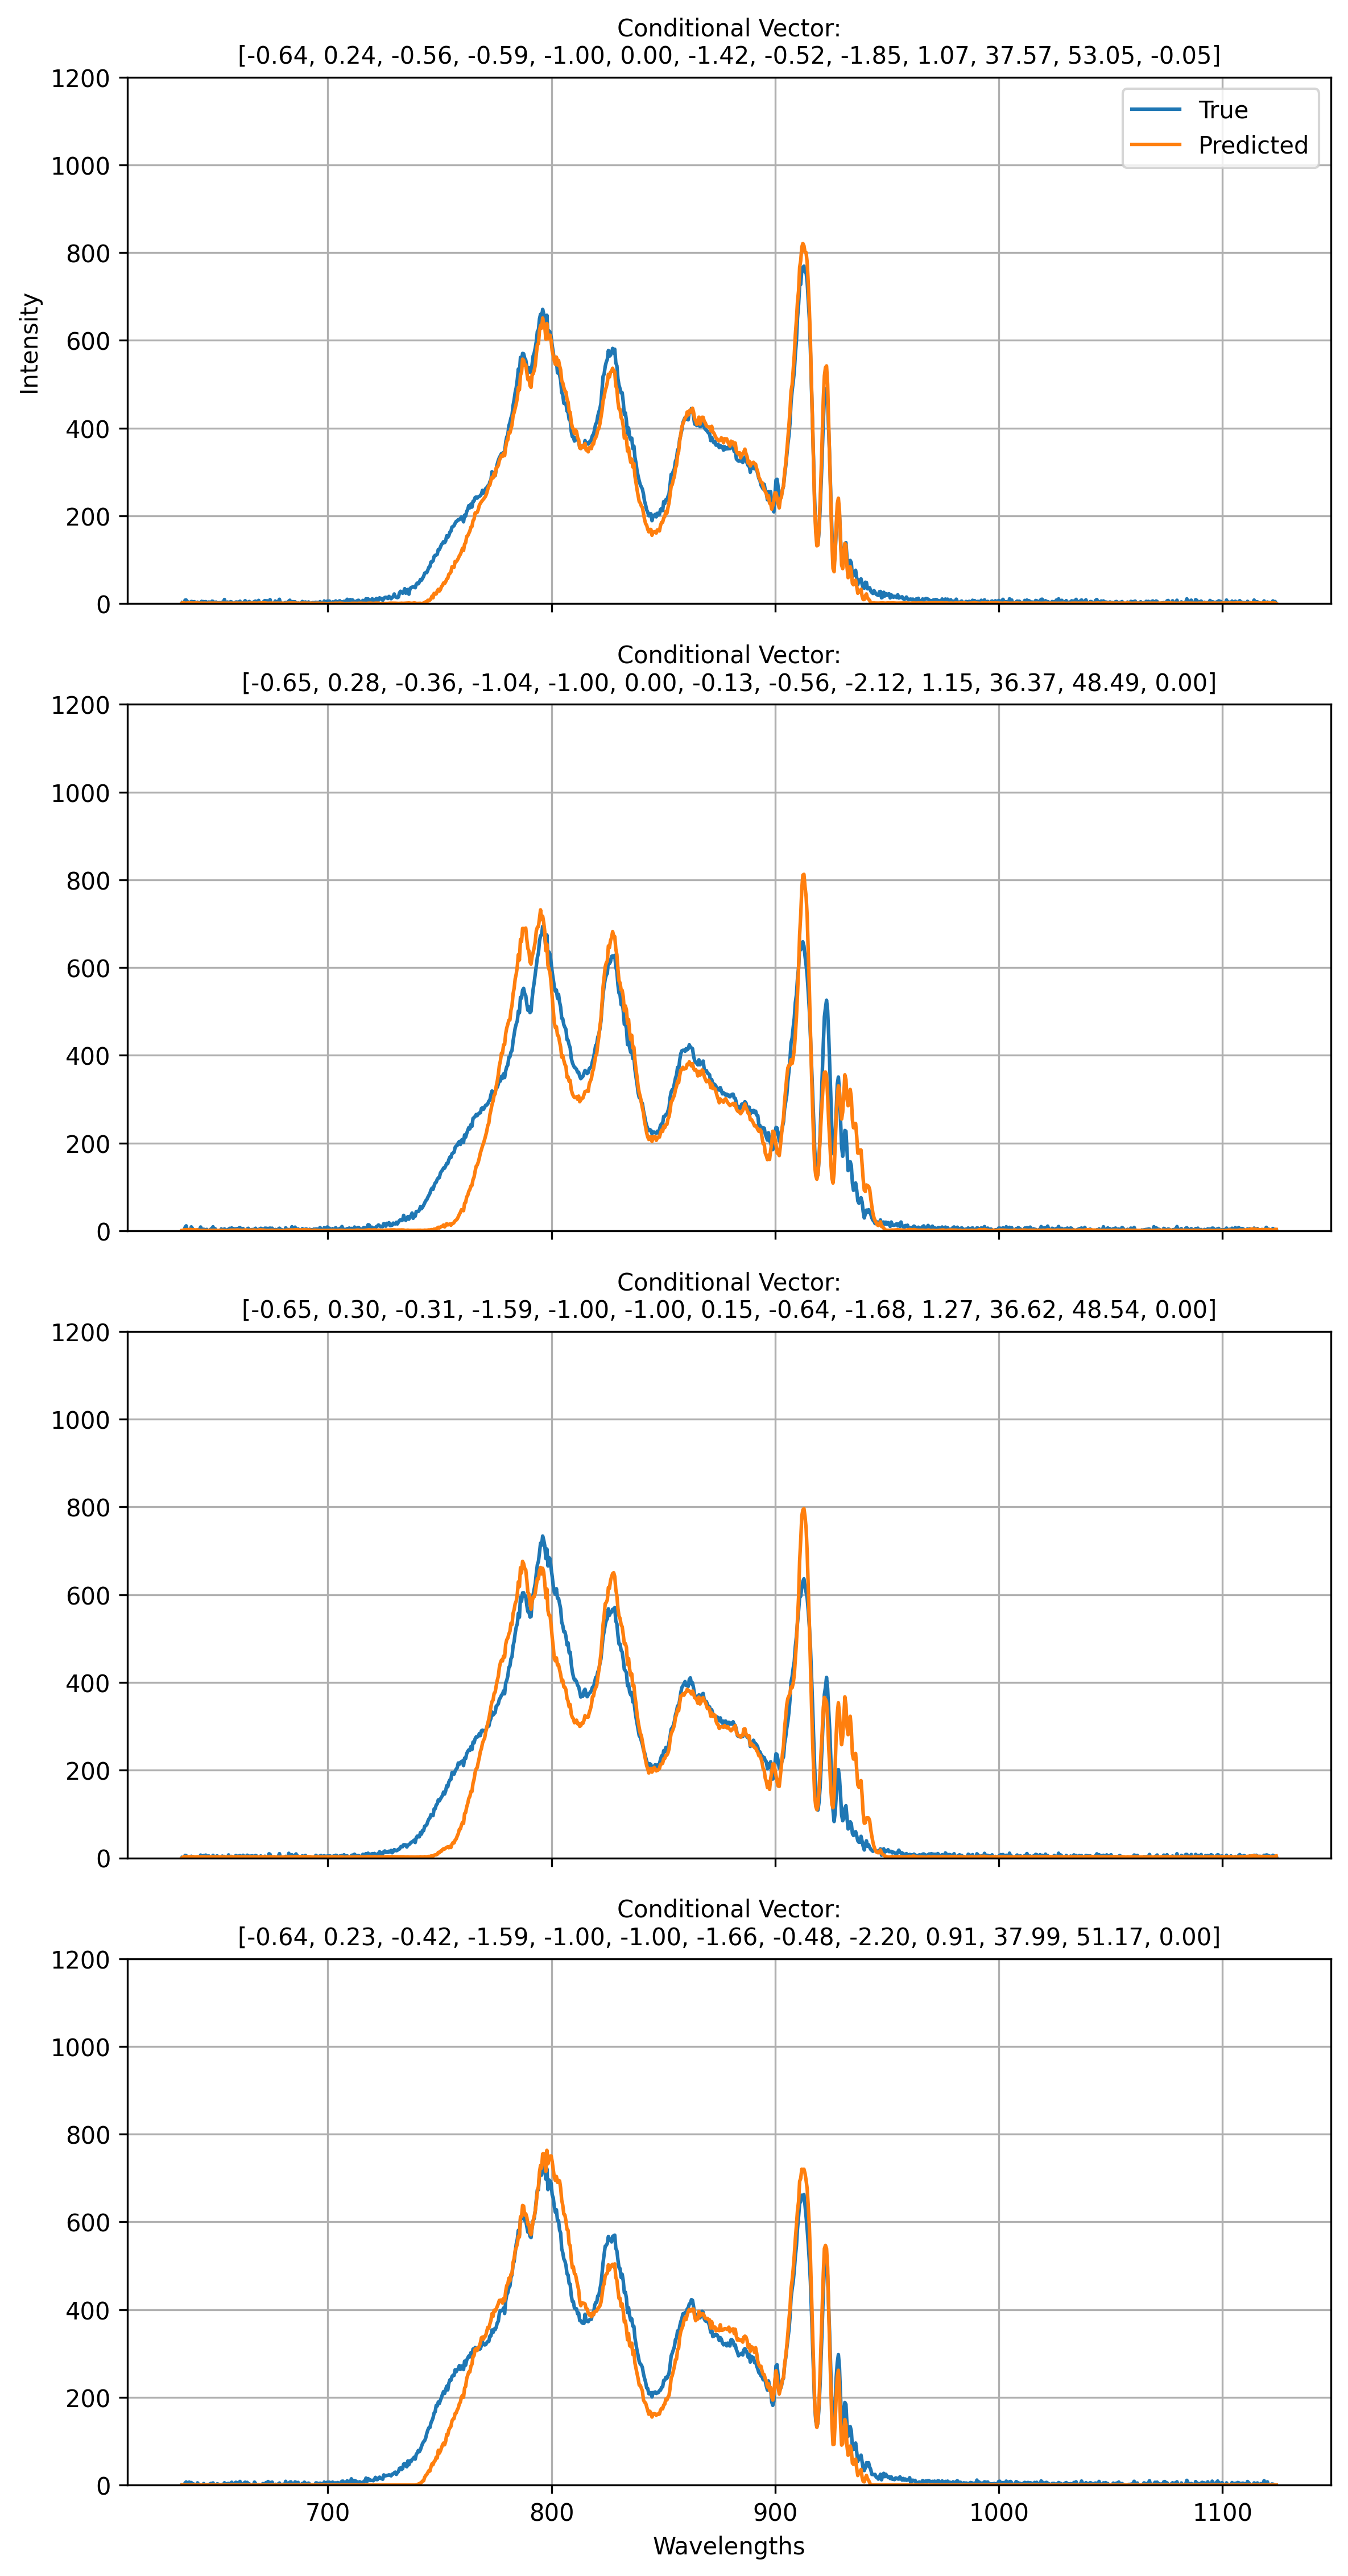

In [14]:
indices = np.random.choice(len(x_real), size=4, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=4
)

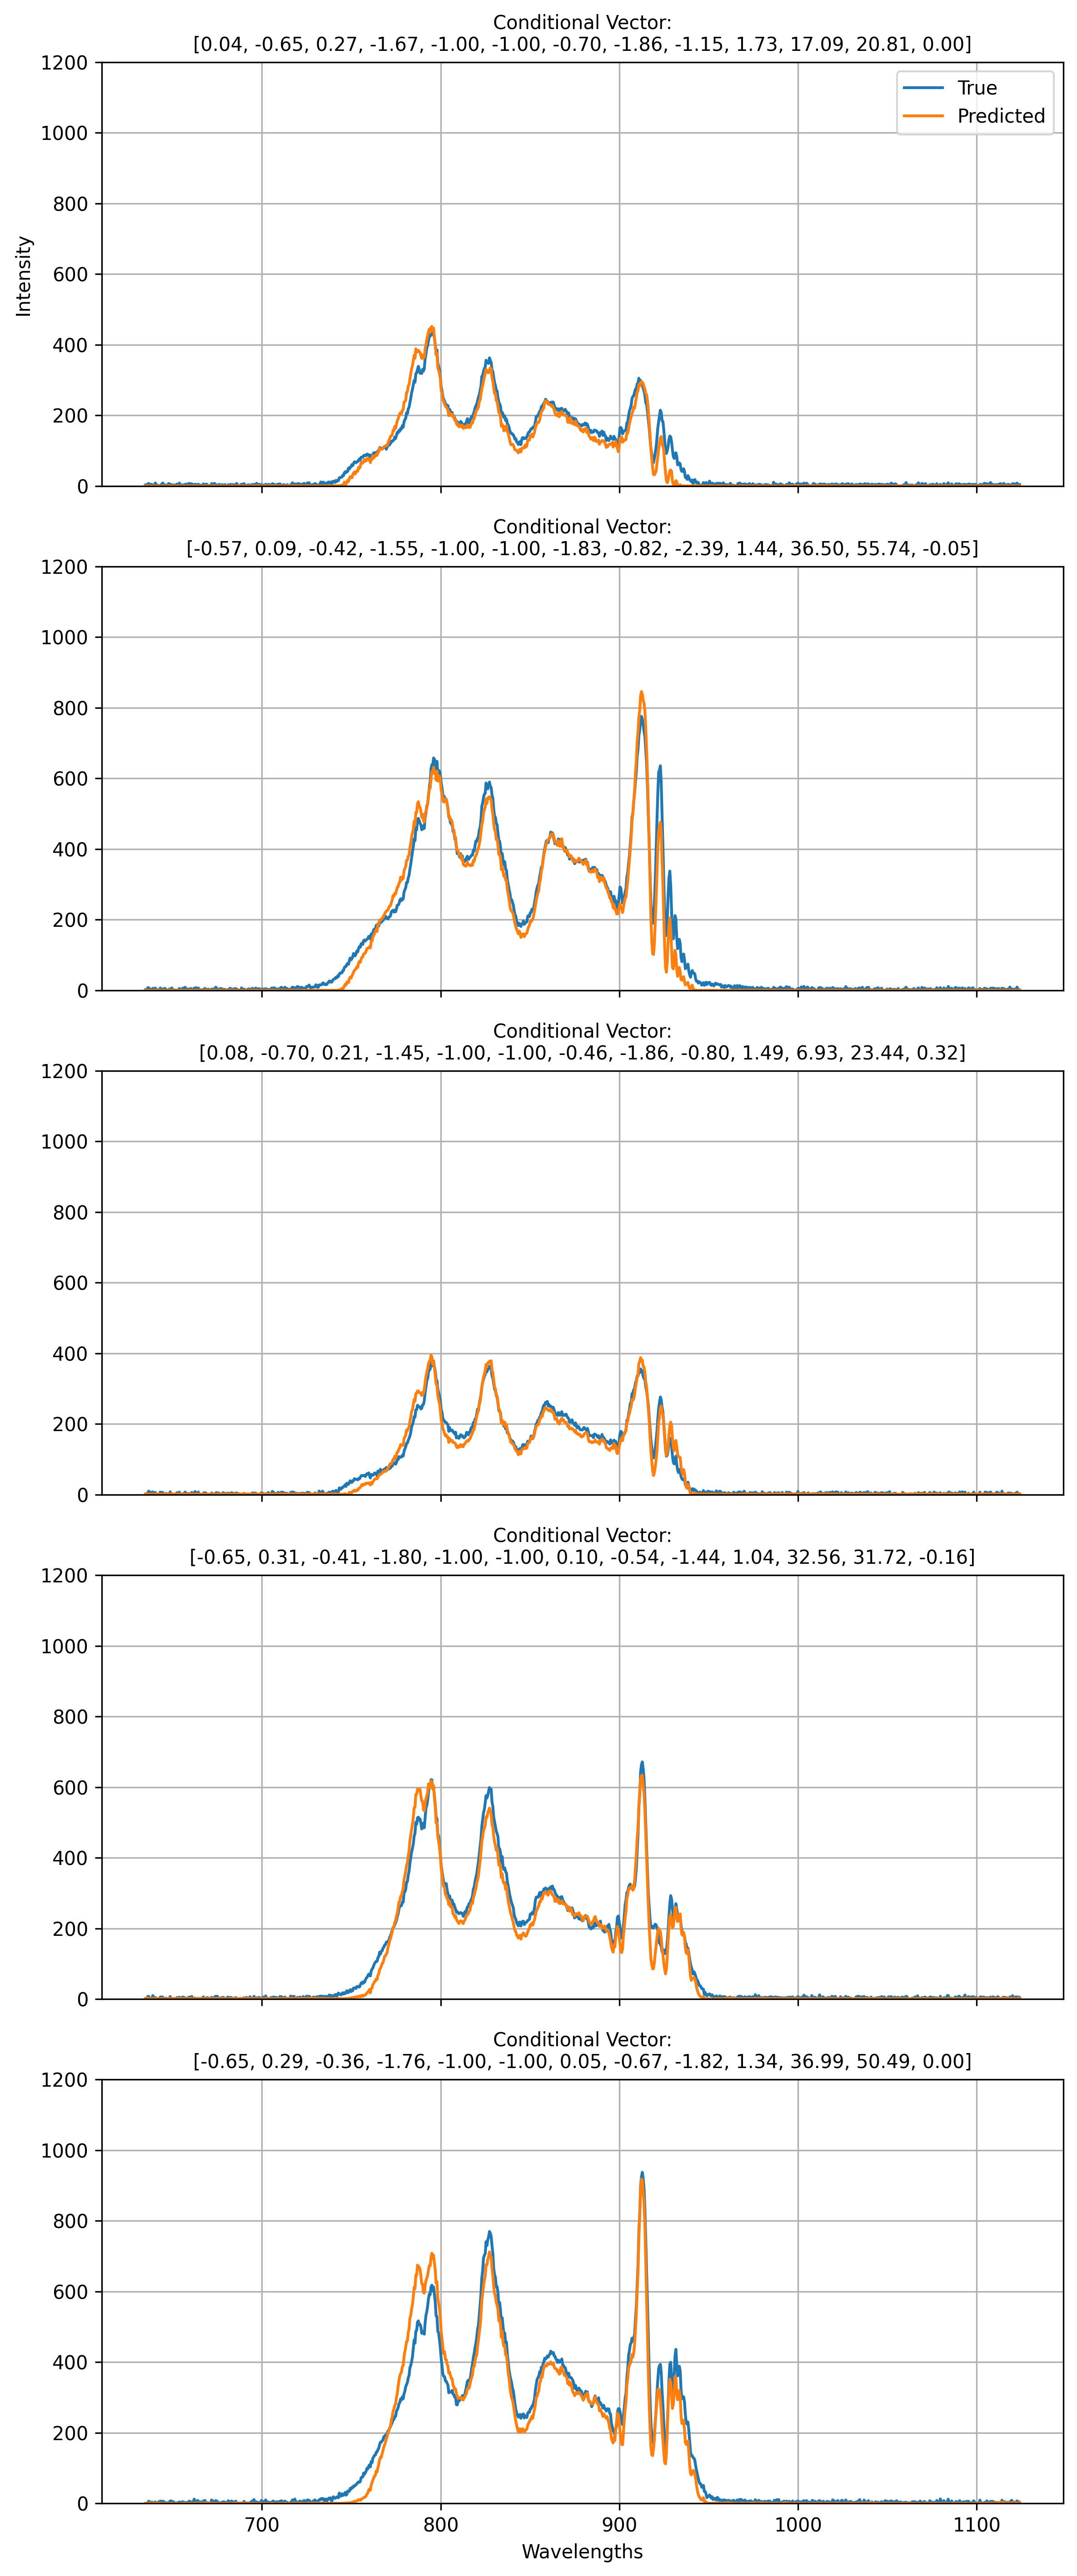

In [15]:
indices = np.array([456, 4146, 254, 5713, 10537, 17518])

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=5
)

[ 18  66 188 143 228 130 214 209 115 146]


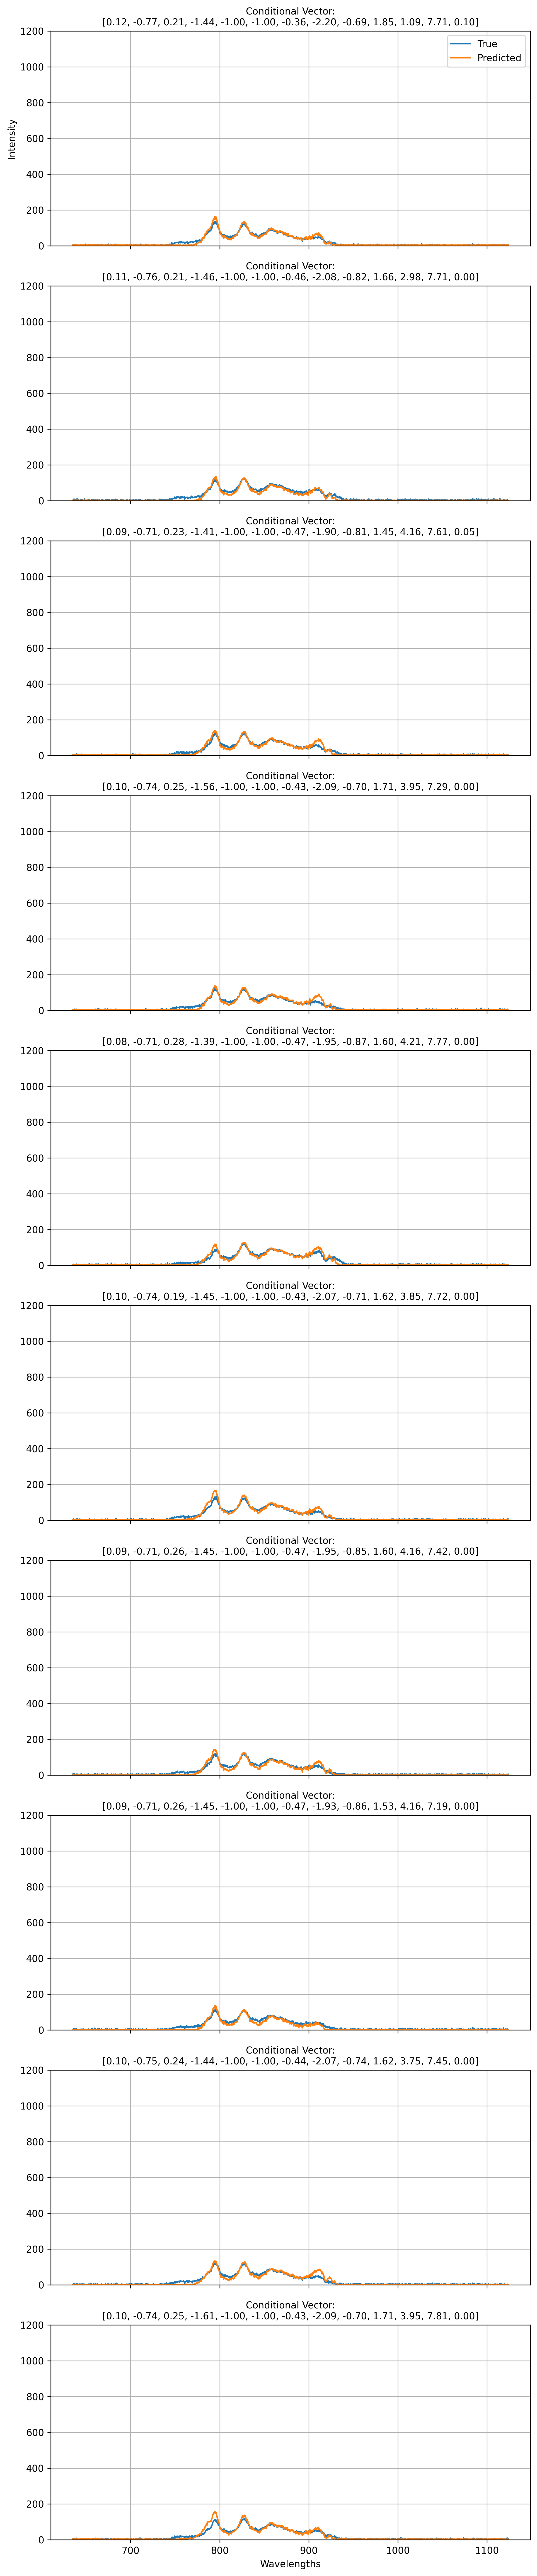

In [16]:
best_indices = get_best_mse_indices(x_real, predictions, n=10)
print(best_indices)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, best_indices, num_vectors=10
)

[ 3318   250  3280  3205  3191 16660   288 17104 16662   251]


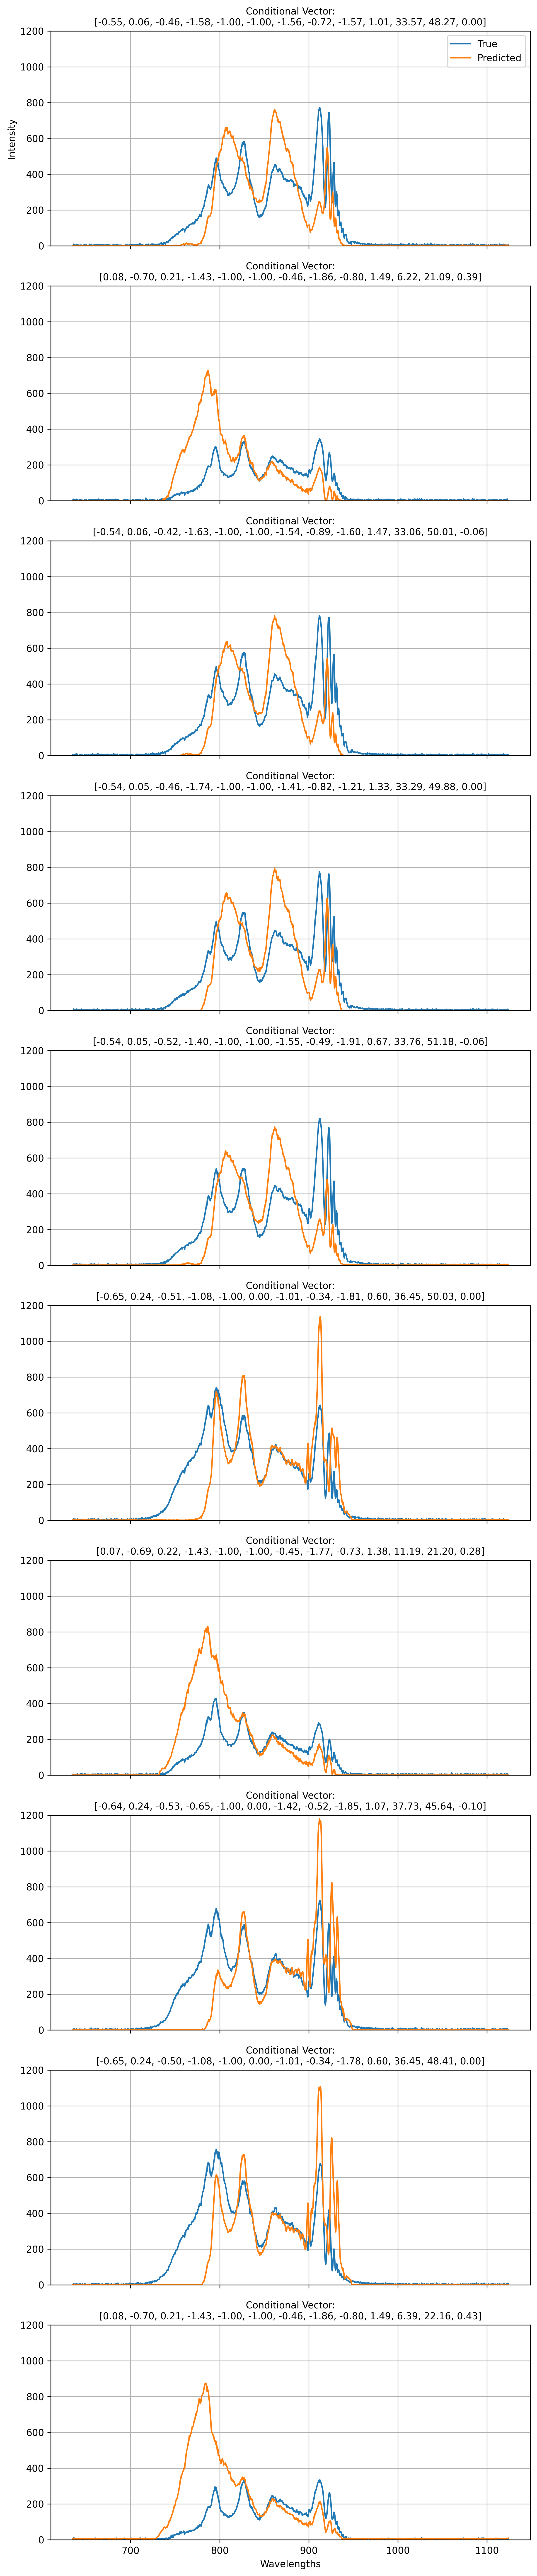

In [17]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
print(worst_indices)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 2612.6711
Median: 2502.1999
Standard Deviation: 1409.0315
Min: 46.3999
Max: 30428.9277
Range: 30382.5278
Median (Q2): 2502.1999
First Quartile (Q1): 1998.7528
Third Quartile (Q3): 2975.8728
Interquartile Range (IQR): 977.1200
Upper Whisker: 4441.5528
Number of Outliers: 1462.0000
Outliers: [117.58004769100486, 264.7477249904112, 265.0062611321305, 375.3236196322022, 392.0560990835279, 102.03393441661566, 89.8036408700776, 373.5944573504356, 46.39994117900559, 116.95246909556056]...


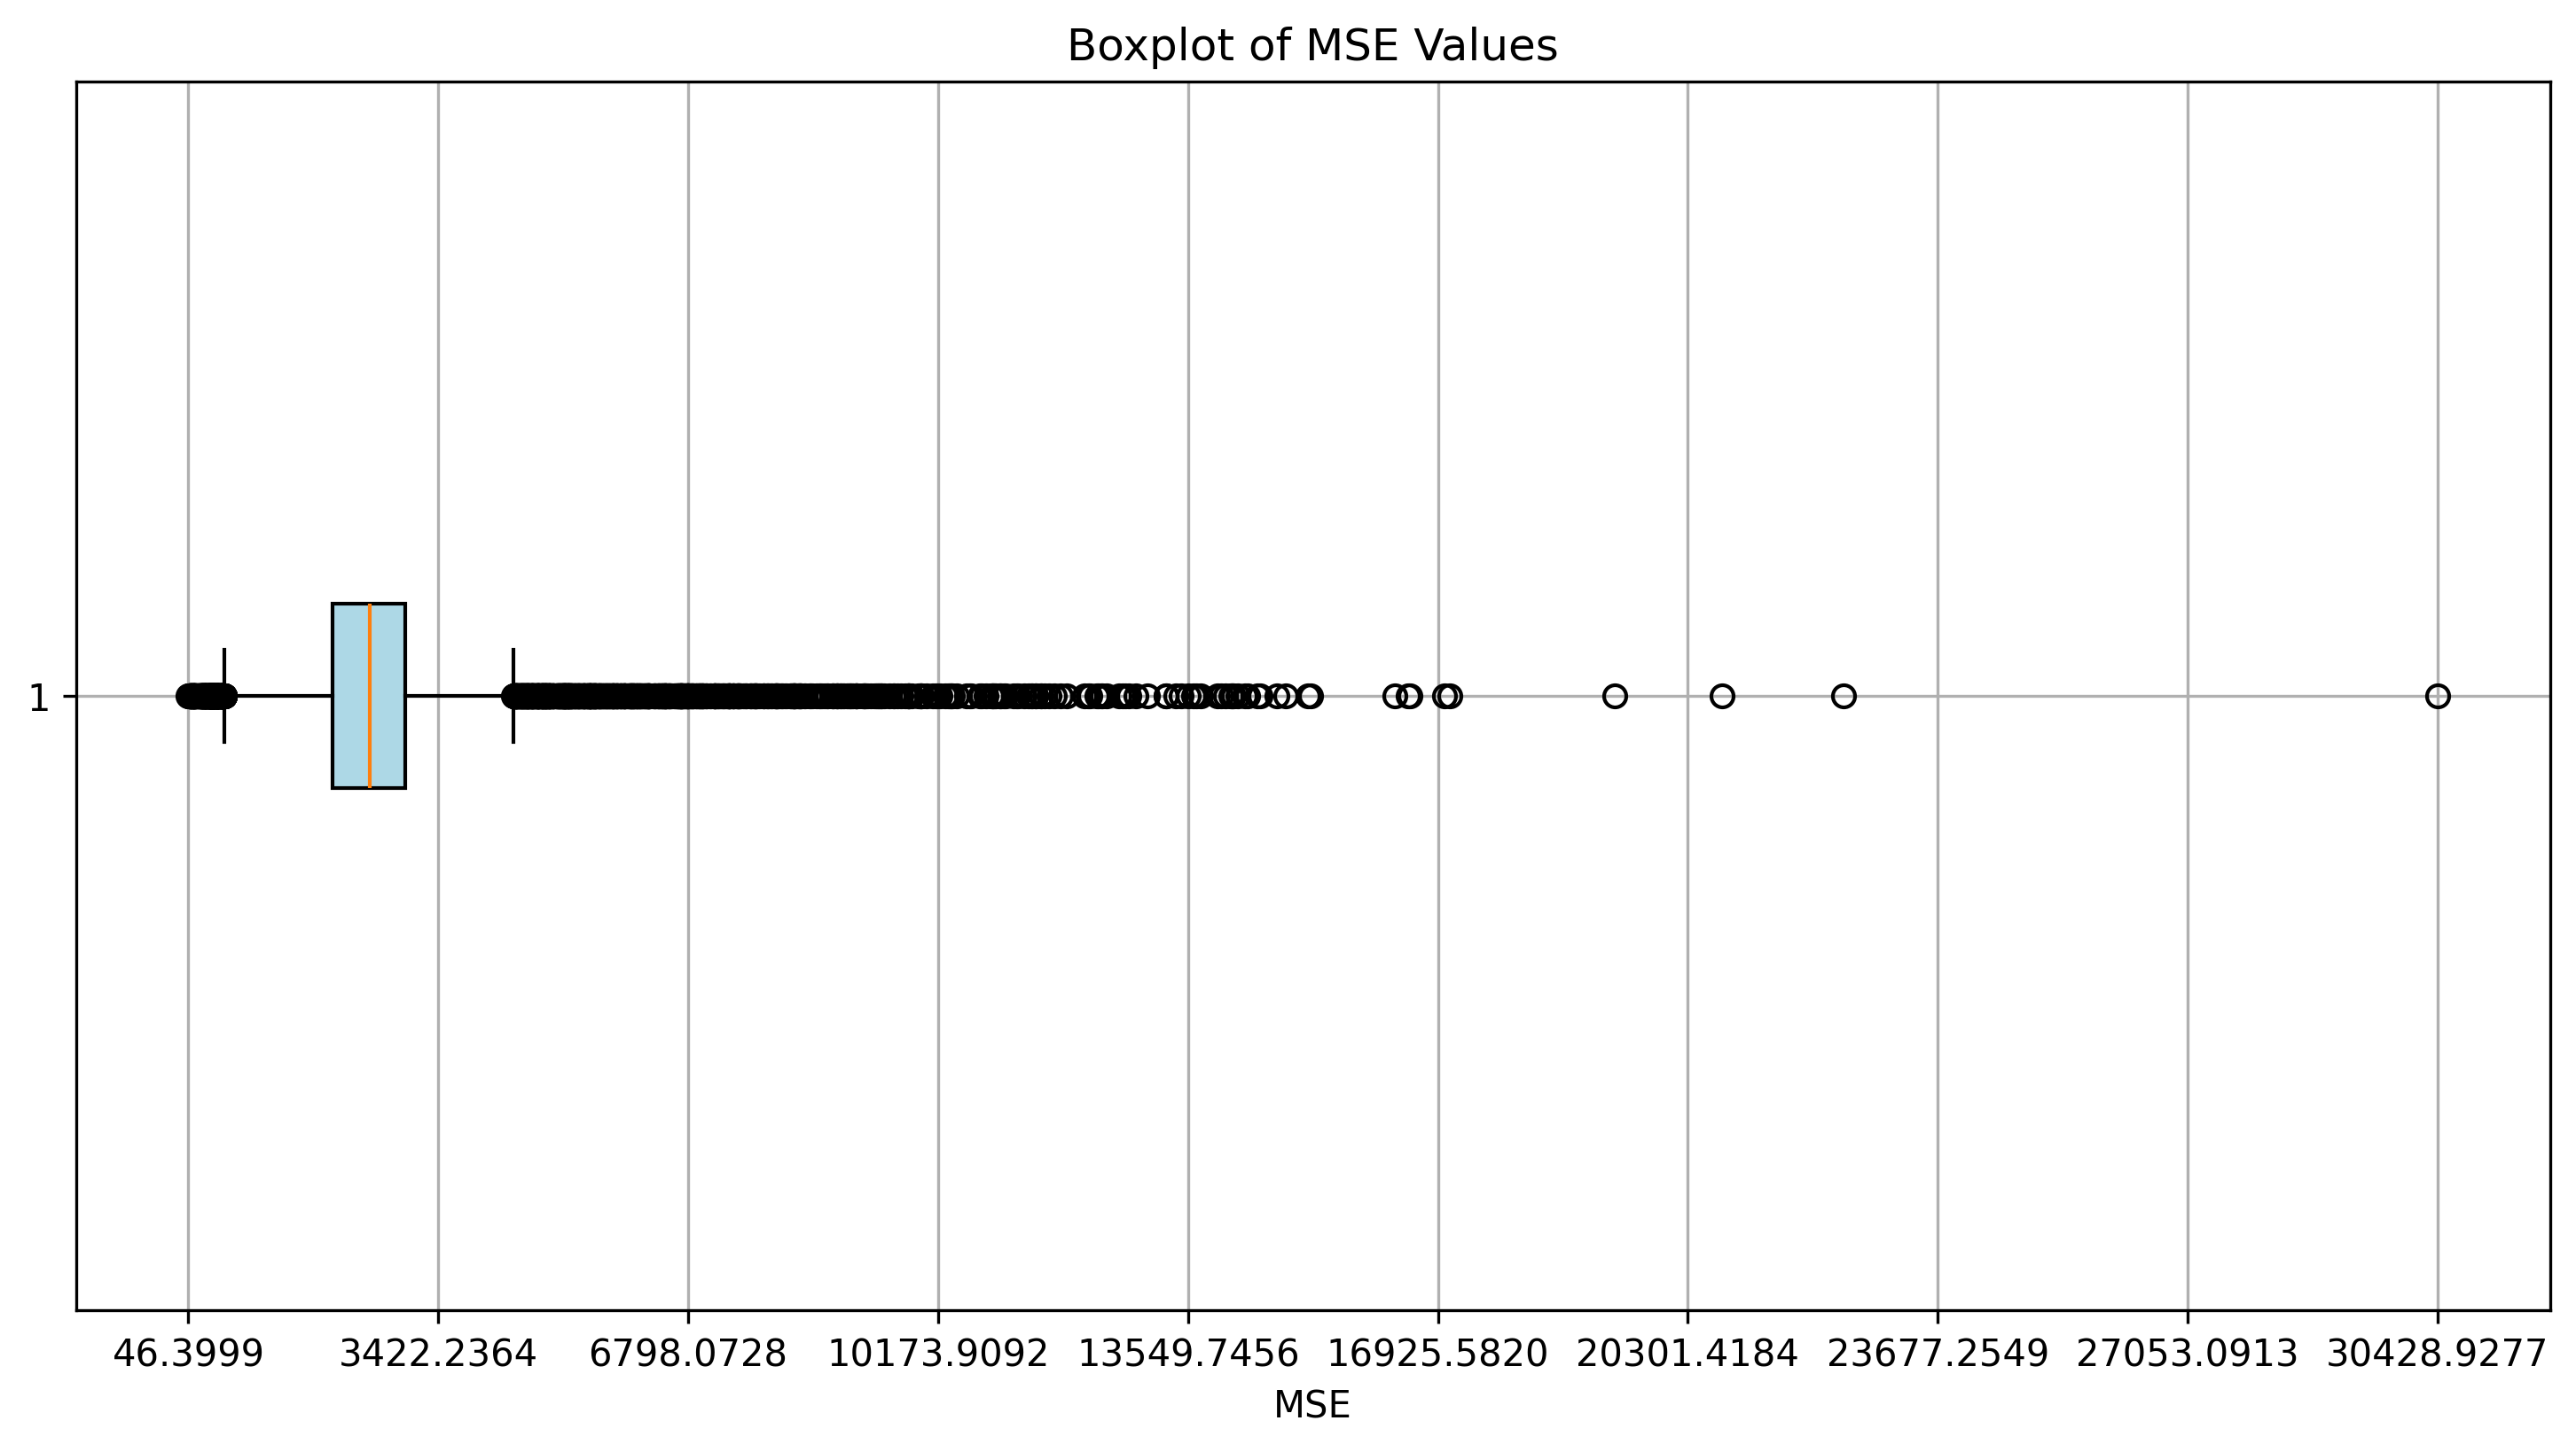

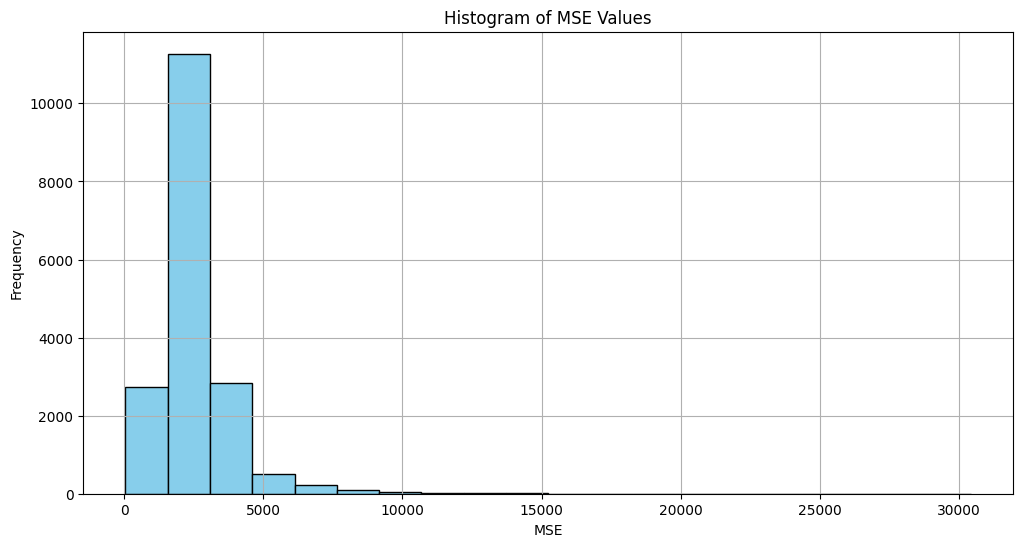

In [18]:
mse_stats = mse_statistics(x_real, predictions)

## Compare distributions

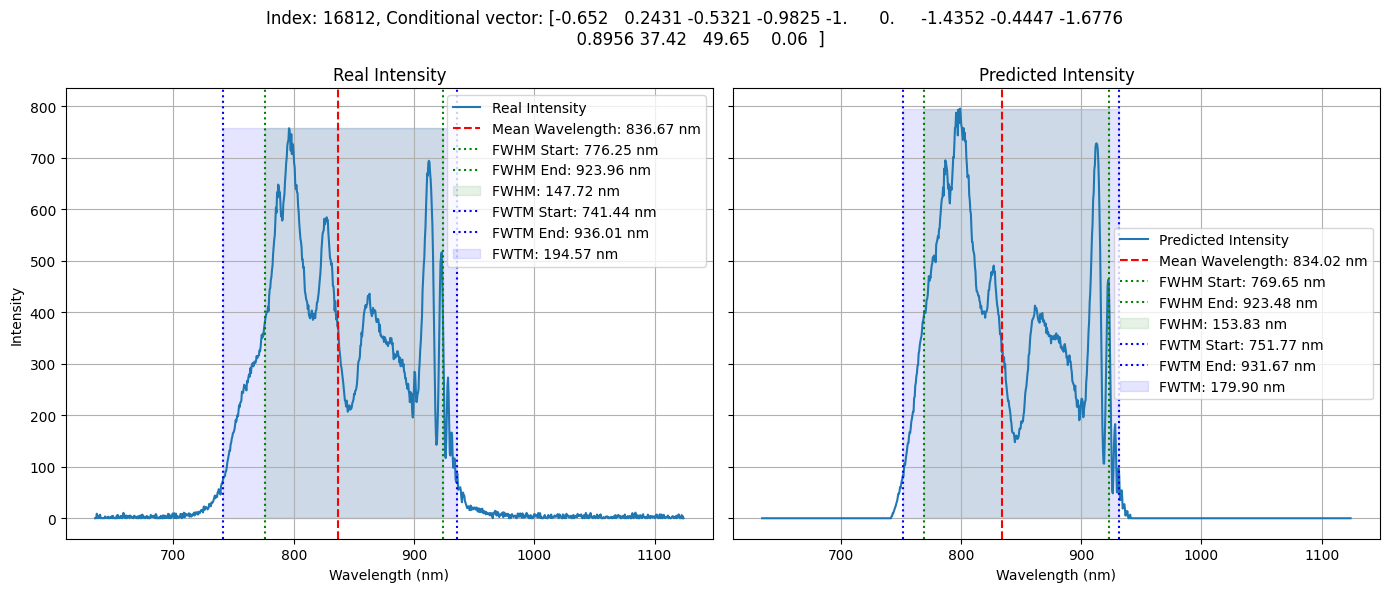

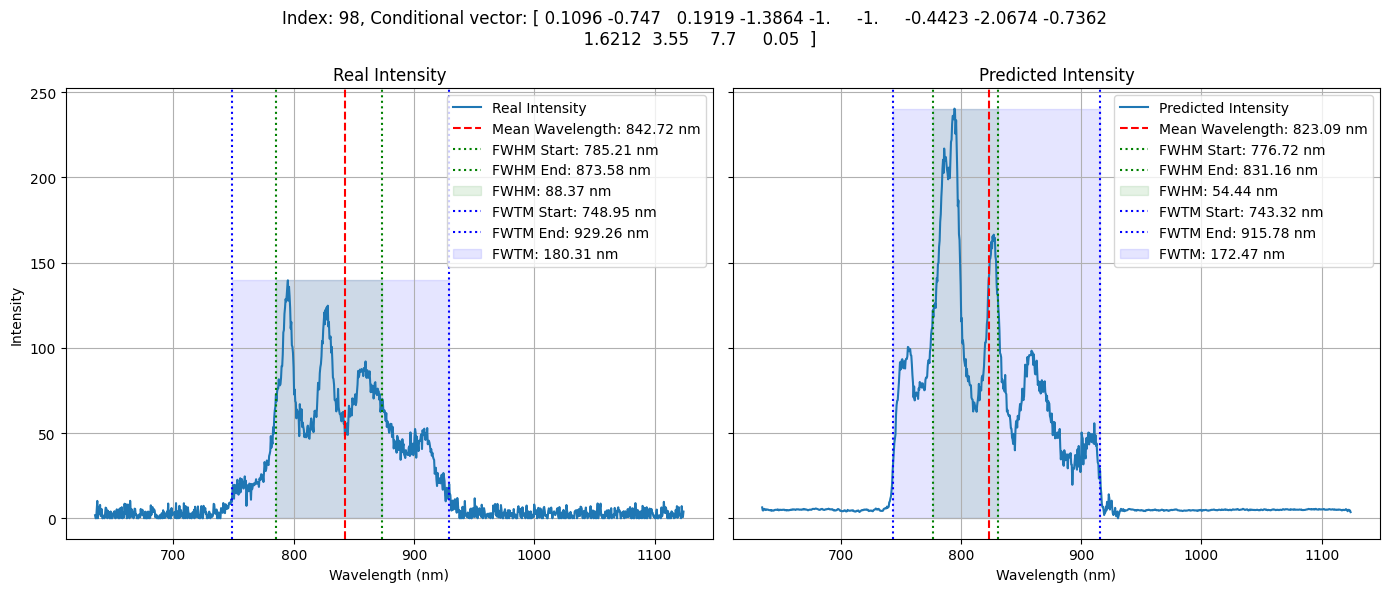

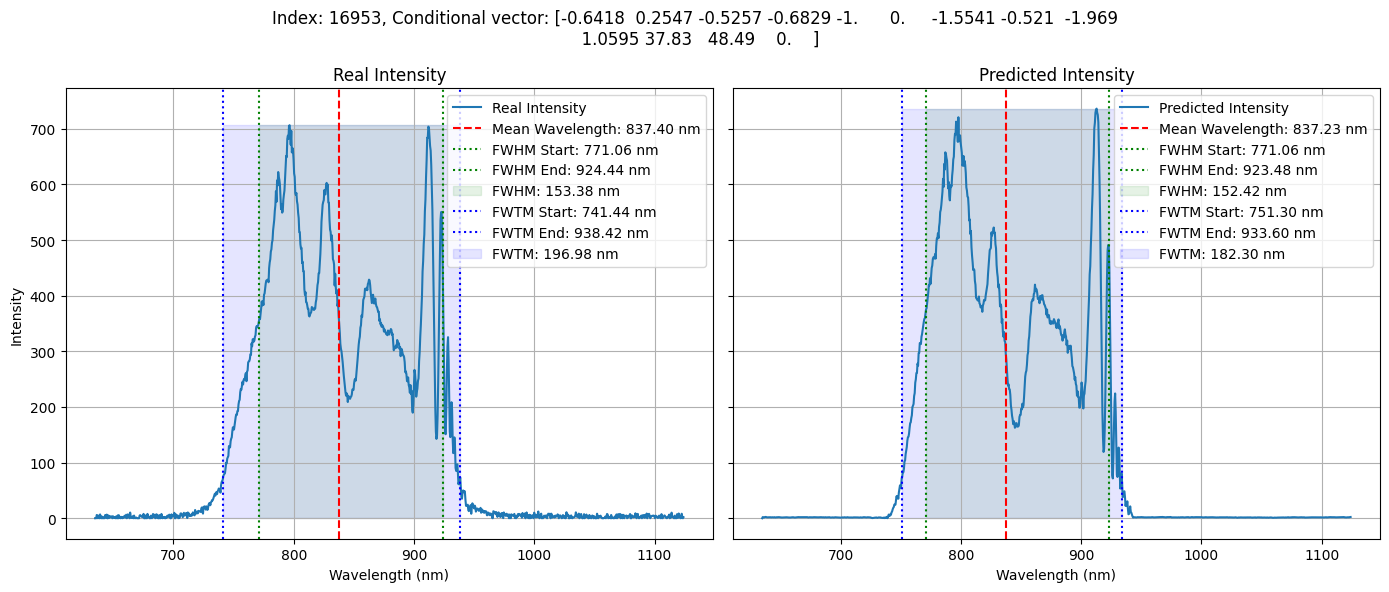

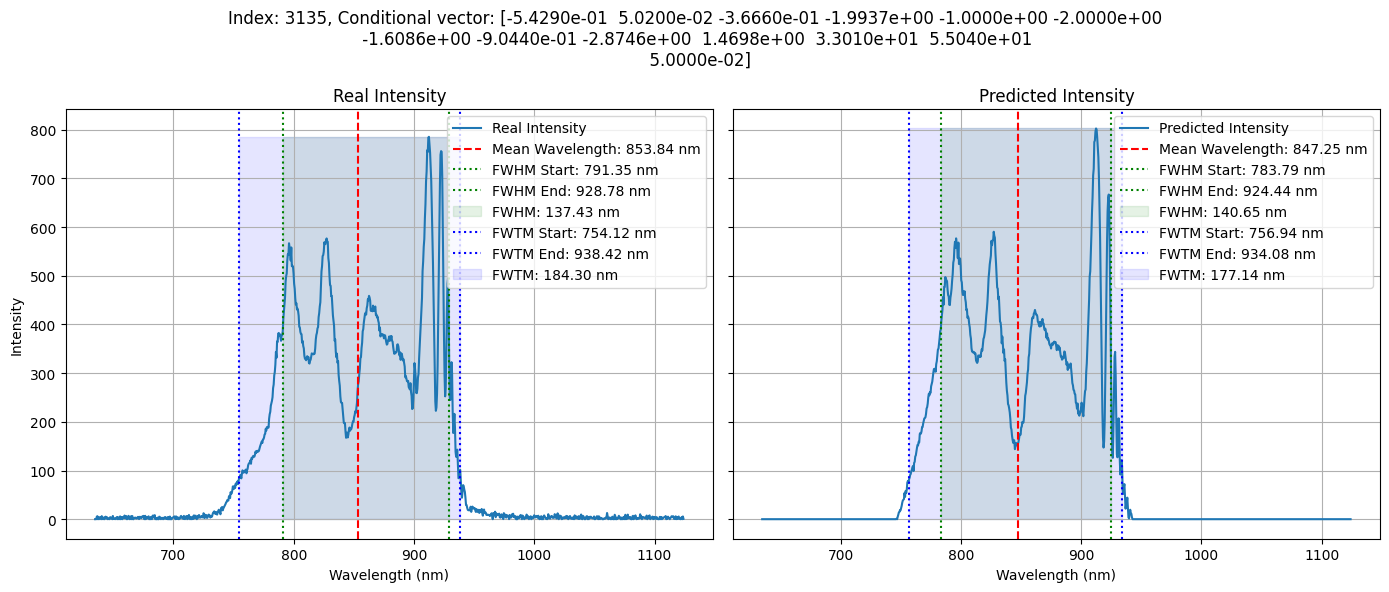

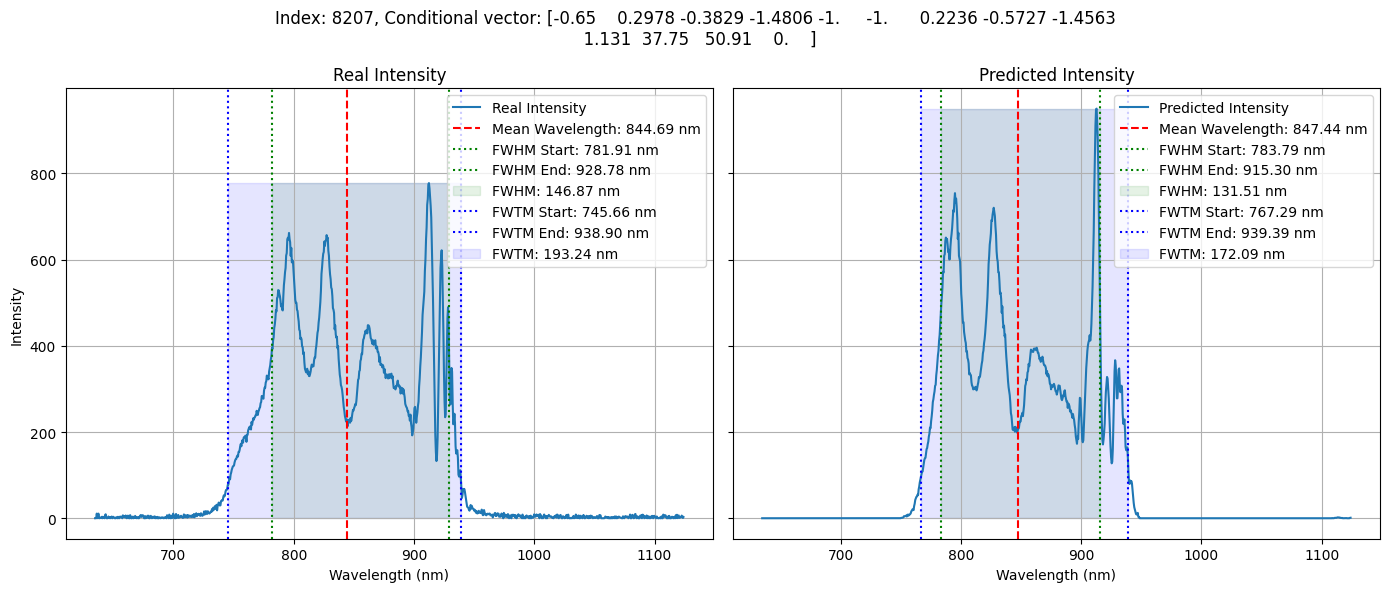

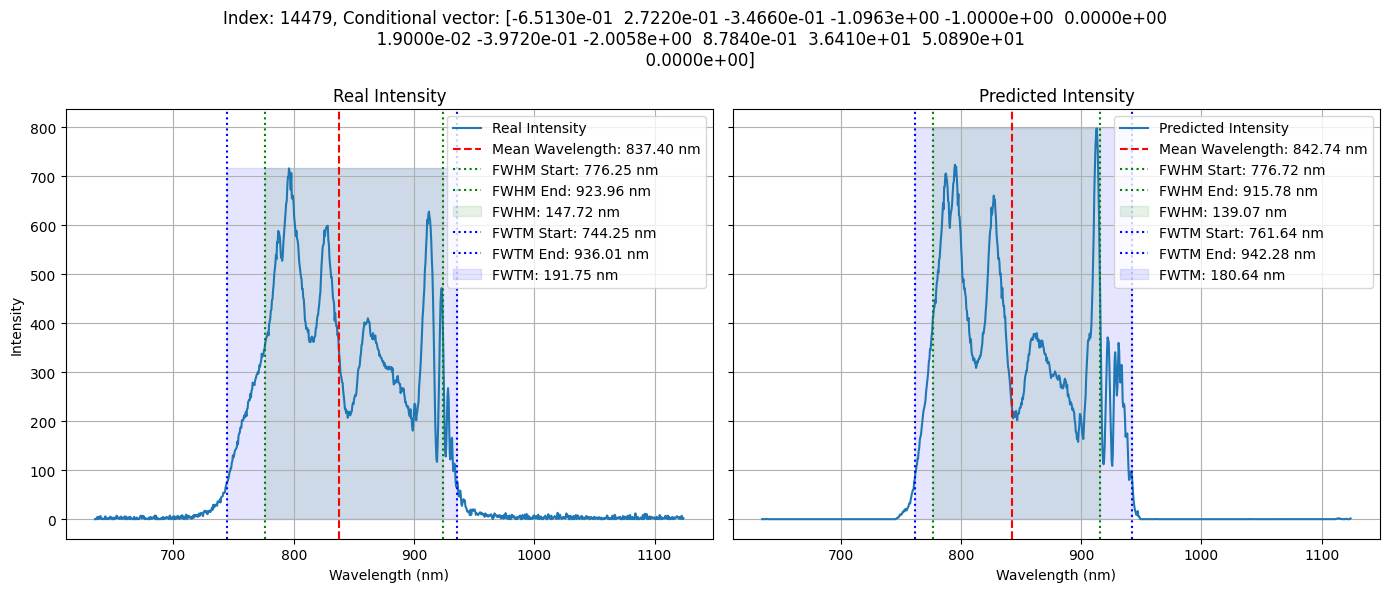

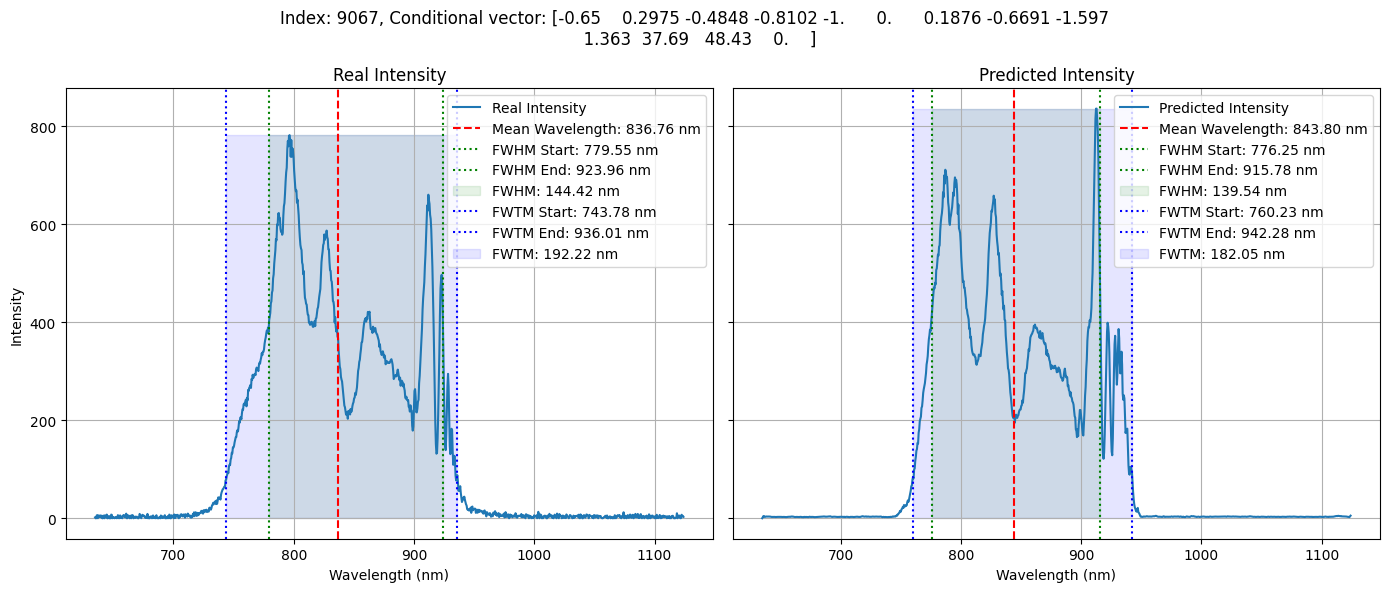

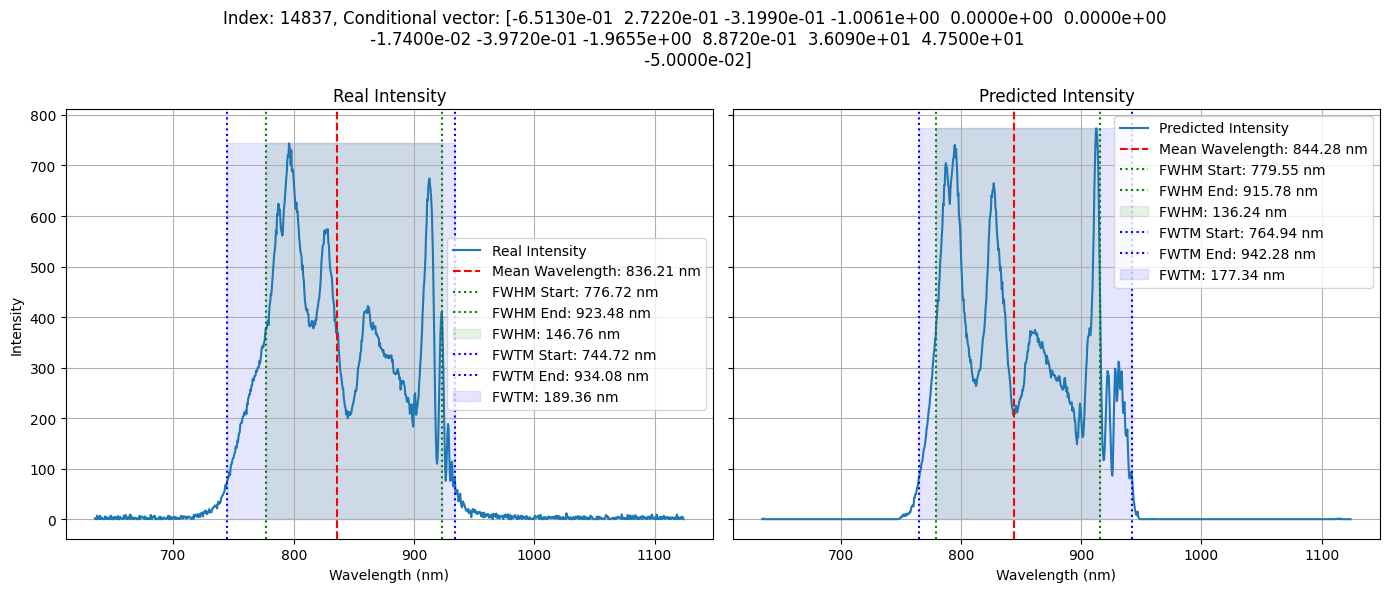

In [19]:
rand_ind = random.randint(len(x_real), size=(10))
for i in rand_ind:
    plot_comparison(index=i, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

In [20]:
# Calculate MSE and MAE for the metrics
mse_results, mae_results = calculate_metrics_errors(wavelengths, x_real, predictions)

+-----------------+----------+----------+
| Metric          |      MSE |      MAE |
+=================+==========+==========+
| mean_wavelength |  64.8445 |  5.89403 |
+-----------------+----------+----------+
| std_deviation   |  22.5025 |  3.73905 |
+-----------------+----------+----------+
| fwhm            | 188.371  |  9.02852 |
+-----------------+----------+----------+
| fwhm_start      |  47.5669 |  5.1839  |
+-----------------+----------+----------+
| fwhm_end        | 224.085  |  8.99795 |
+-----------------+----------+----------+
| fwtm            | 235.79   | 11.3755  |
+-----------------+----------+----------+
| fwtm_start      | 229.902  | 13.3098  |
+-----------------+----------+----------+
| fwtm_end        |  88.3089 |  5.1665  |
+-----------------+----------+----------+


### DTW

In [21]:
dtw_distances = calculate_dtw_distances(x_real, predictions)
mean_dtw = np.mean(dtw_distances)
print(f"Mean DTW Distance: {mean_dtw:.6f}")

Mean DTW Distance: 9504.935428


In [22]:
min_values = np.min(dtw_distances, axis=0)  
max_values = np.max(dtw_distances, axis=0)  
mean_values = np.mean(dtw_distances, axis=0)  
median_values = np.median(dtw_distances, axis=0)  

print("Min:", min_values)
print("Max:", max_values)
print("Mean:", mean_values)
print("Median:", median_values)

Min: 3055.2946619700033
Max: 41077.105338899986
Mean: 9504.935427974122
Median: 9403.861939070004


DTW Distance for index 456: 4989.688522


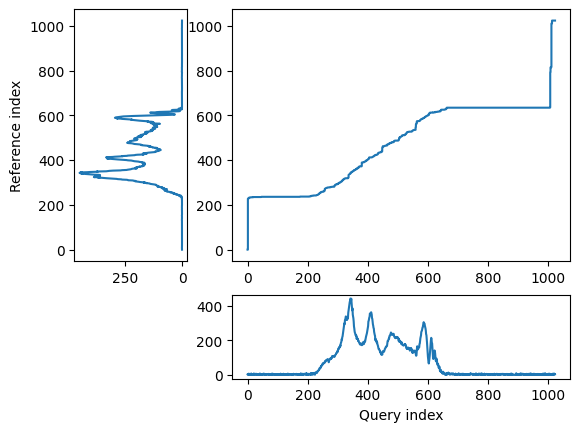

In [23]:
plot_dtw_alignment_for_index(x_real, predictions, 456)

DTW Distance for index 5713: 6887.379876


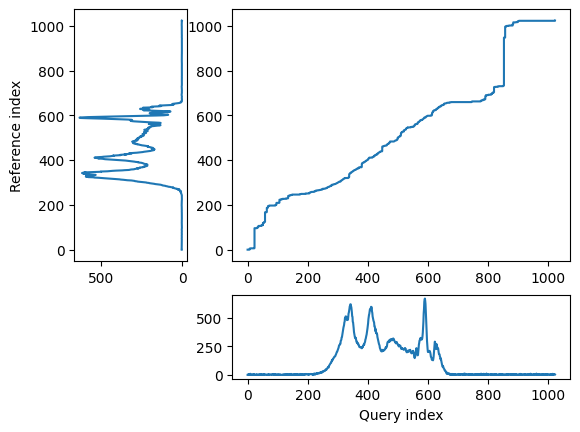

In [24]:
plot_dtw_alignment_for_index(x_real, predictions, 5713)

DTW Distance for index 456: 4989.688522


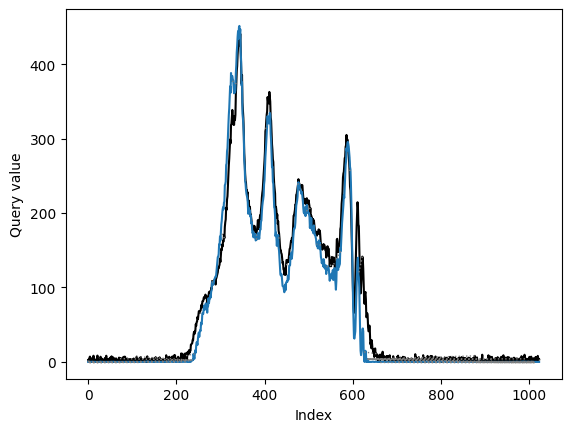

In [25]:
plot_dtw_alignment_for_index(x_real, predictions, 456, plot_type="twoway")

DTW Distance for index 5713: 6887.379876


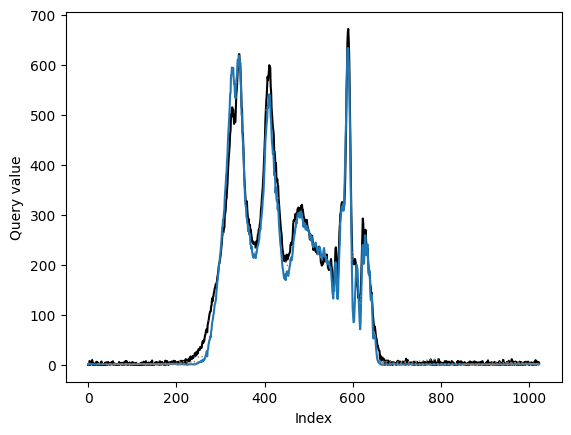

In [26]:
plot_dtw_alignment_for_index(x_real, predictions, 5713, plot_type="twoway")

### Wasserstein

In [27]:
wasserstein_distances, avg_distance = calculate_wasserstein_distance(x_real, predictions)
print(f"Average Wasserstein Distance: {avg_distance}")

Average Wasserstein Distance: 20.901819718789866


In [28]:
min_values = np.min(wasserstein_distances, axis=0)  
max_values = np.max(wasserstein_distances, axis=0)  
mean_values = np.mean(wasserstein_distances, axis=0)  
median_values = np.median(wasserstein_distances, axis=0)  

print("Min:", min_values)
print("Max:", max_values)
print("Mean:", mean_values)
print("Median:", median_values)

Min: 0.1846163461378615
Max: 146.13923323929606
Mean: 20.901819718789866
Median: 6.5470416574770685
